In [ ]:
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import fsolve
import pandas as pd
from google.colab import files

# All functions

In [ ]:
def calculate_parameters(distribution_choice, beta_e, beta_p, gamma, R, y_lower, y_upper, y_3, y_1, y_mode, y_mean, sigma):
    b_num_points = 1000
    sigma = np.sqrt(sigma) # normal
    psi = np.log(y_3) - np.log(gamma * y_3)
    b_upper_e = (1 - gamma * np.exp(- beta_e * psi)) * y_upper
    b_lower_e = (1 - gamma * np.exp(- beta_e * psi)) * y_lower
    b_upper_p = (1 - gamma * np.exp(- beta_p * psi)) * y_upper
    b_lower_p = (1 - gamma * np.exp(- beta_p * psi)) * y_lower

    # Different distributions, PDF, and CDF
    uniform_pdf = lambda y: 1 / (y_upper - y_lower) if y_lower <= y <= y_upper else 0

    def normal_pdf(y):
        normalization_constant = norm.cdf(y_upper, y_mean, sigma) - norm.cdf(y_lower, y_mean, sigma)

        if y_lower <= y <= y_upper:
            pdf_at_y = norm.pdf(y, y_mean, sigma)
            truncated_pdf = pdf_at_y / normalization_constant
            return truncated_pdf
        else:
            return 0

    def triangular_pdf(y):
        if y_lower <= y <= y_mode:
            return 2 * (y - y_lower) / ((y_upper - y_lower) * (y_mode - y_lower))
        elif y_mode < y <= y_upper:
            return 2 * (y_upper - y) / ((y_upper - y_lower) * (y_upper - y_mode))
        else:
            return 0

    def normal_cdf(y):
        cdf_at_y = norm.cdf(y, y_mean, sigma)
        cdf_at_y_lower = norm.cdf(y_lower, y_mean, sigma)
        cdf_at_y_upper = norm.cdf(y_upper, y_mean, sigma)
        if y < y_lower:
            return 0
        elif y > y_upper:
            return 1
        else:
            return (cdf_at_y - cdf_at_y_lower) / (cdf_at_y_upper - cdf_at_y_lower)

    def uniform_cdf(y):
        if y < y_lower:
            return 0
        elif y_lower <= y <= y_upper:
            return (y - y_lower) / (y_upper - y_lower)
        else:
            return 1

    def triangular_cdf(y):
        if y < y_lower:
            return 0
        elif y_lower <= y < y_mode:
            return ((y - y_lower)**2) / ((y_upper - y_lower) * (y_mode - y_lower))
        elif y_mode <= y <= y_upper:
            return 1 - ((y_upper - y)**2) / ((y_upper - y_lower) * (y_upper - y_mode))
        else:
            return 1

    if distribution_choice == 'triangular':
        chosen_cdf = triangular_cdf
        chosen_pdf = triangular_pdf
    elif distribution_choice == 'uniform':
        chosen_cdf = uniform_cdf
        chosen_pdf = uniform_pdf
    elif distribution_choice == 'normal':
        chosen_cdf = normal_cdf
        chosen_pdf = normal_pdf

    # Calculating U_E
    def Total_U_e(b, cdf, pdf):
        y_tau = b / (1 - gamma * np.exp(-beta_e * psi))
        cdf_value = cdf(y_tau)
        q_e = (1 / R) * (1 - cdf_value)

        # Initialize integral_case_1 to 0 to ensure it has a value even if not calculated
        integral_case_1 = 0

        # Compute integral_case_1 only if b is less than y_lower
        if b < y_lower:
            integral_case_1, _ = quad(lambda y_2: np.log(y_2 - b) * pdf(y_2) if y_2 > b else 0, y_lower, y_upper)

        def integrand_case_2_1(y_2):
            return np.log(y_2 - b) * pdf(y_2) if y_2 > b else 0  # Ensure logarithm is computed for valid values only

        def integrand_case_2_2(y_2):
            return np.log(gamma * y_2) * pdf(y_2)

        integral_case_2_1, _ = quad(integrand_case_2_1, max(y_tau, b), y_upper)  # Ensure y_2 > b
        integral_case_2_2, _ = quad(integrand_case_2_2, y_lower, y_tau)
        integral_case_3, _ = quad(lambda y_2: np.log(gamma * y_2) * pdf(y_2), y_lower, y_upper)

        U_period_1 = np.log(y_1 + q_e * b)
        U_period_2 = ((1 if y_lower < y_tau < y_upper else 0) *
                      (beta_e * integral_case_2_1 + beta_e * integral_case_2_2) +
                      (1 if y_tau <= y_lower else 0) * (beta_e * integral_case_1) +  # Use <= to include equality
                      (1 if y_tau > y_upper else 0) * (beta_e * integral_case_3))
        U_period_3 = ((beta_e ** 2) * np.log(y_3) * (1 - cdf_value) +
                      (beta_e ** 2) * np.log(gamma * y_3) * cdf_value)

        U_total = U_period_1 + U_period_2 + U_period_3
        return U_total

    # Calculating b_E_hat
    def calculate_U_uniform_for_b_hat_e(b, cdf, pdf):
        y_tau = b / (1 - gamma * np.exp(-beta_p * psi))
        cdf_uniform = cdf(y_tau)
        q_uniform_e = (1 / R) * (1 - cdf_uniform)

        # Initialize integral_case_1_uniform to 0 to ensure it has a value even if not calculated
        integral_case_1_uniform = 0

        # Compute integral_case_1_uniform only if b is less than y_lower
        if b < y_lower:
            integral_case_1_uniform, _ = quad(lambda y_2: np.log(y_2 - b) * pdf(y_2) if y_2 > b else 0, y_lower, y_upper)

        def integrand_case_2_1_uniform(y_2):
            return np.log(y_2 - b) * pdf(y_2) if y_2 > b else 0  # Ensure logarithm is computed for valid values only

        def integrand_case_2_2_uniform(y_2):
            return np.log(gamma * y_2) * pdf(y_2)

        integral_case_2_1_uniform, _ = quad(integrand_case_2_1_uniform, max(y_tau, b), y_upper)  # Ensure y_2 > b
        integral_case_2_2_uniform, _ = quad(integrand_case_2_2_uniform, y_lower, y_tau)
        integral_case_3_uniform, _ = quad(lambda y_2: np.log(gamma * y_2) * pdf(y_2), y_lower, y_upper)

        U_period_1 = np.log(y_1 + q_uniform_e * b)
        U_period_2 = ((1 if y_lower < y_tau < y_upper else 0) *
                      (beta_e * integral_case_2_1_uniform + beta_e * integral_case_2_2_uniform) +
                      (1 if y_tau <= y_lower else 0) * (beta_e * integral_case_1_uniform) +  # Use <= to include equality
                      (1 if y_tau > y_upper else 0) * (beta_e * integral_case_3_uniform))
        U_period_3 = ((beta_e ** 2) * np.log(y_3) * (1 - cdf_uniform) +
                      (beta_e ** 2) * np.log(gamma * y_3) * cdf_uniform)

        U_uniform_for_b_hat_e = U_period_1 + U_period_2 + U_period_3
        return U_uniform_for_b_hat_e

    # caclulating U_p
    def Total_U_p(b, cdf, pdf):
        y_tau = b / (1 - gamma * np.exp(-beta_p * psi))
        cdf_value = cdf(y_tau)
        q_p = (1 / R) * (1 - cdf_value)
        integral_case_1 = 0
        if b < y_lower:
            integral_case_1, _ = quad(lambda y_2: np.log(y_2 - b) * pdf(y_2), y_lower, y_upper, limit=300)
        def integrand_case_2_1(y_2):
            return np.log(y_2 - b) * pdf(y_2) if y_2 > b else 0  # Add conditional to handle y_2 <= b
        def integrand_case_2_2(y_2):
            return np.log(gamma * y_2) * pdf(y_2)
        integral_case_2_1, _ = quad(integrand_case_2_1, max(y_tau, b), y_upper, limit=300)  # Ensure y_2 > b
        integral_case_2_2, _ = quad(integrand_case_2_2, y_lower, y_tau, limit=300)
        integral_case_3, _ = quad(lambda y_2: np.log(gamma * y_2) * pdf(y_2), y_lower, y_upper, limit=300)
        U_period_1 = np.log(y_1 + q_p * b)
        U_period_2 = ((1 if y_lower < y_tau < y_upper else 0) *
                      (beta_p * integral_case_2_1 + beta_p * integral_case_2_2) +
                      (1 if y_tau <= y_lower else 0) * (beta_p * integral_case_1) +  # Use <= to include equality
                      (1 if y_tau > y_upper else 0) * (beta_p * integral_case_3))
        U_period_3 = ((beta_p ** 2) * np.log(y_3) * (1 - cdf_value) +
                      (beta_p ** 2) * np.log(gamma * y_3) * cdf_value)
        U_total = U_period_1 + U_period_2 + U_period_3
        return U_total

    # do p deviate with q price?
    def Total_U_p_with_price_q_e(b, cdf, pdf):
        y_tau_e = b / (1 - gamma * np.exp(-beta_e * psi))
        y_tau = b / (1 - gamma * np.exp(-beta_p * psi))
        cdf_value = cdf(y_tau_e)
        q_e = (1 / R) * (1 - cdf_value)

        # Initialize integral_case_1 to 0 to ensure it has a value even if not calculated
        integral_case_1 = 0

        # Compute integral_case_1 only if b is less than y_lower
        if b < y_lower:
            integral_case_1, _ = quad(lambda y_2: np.log(y_2 - b) * pdf(y_2) if y_2 > b else 0, y_lower, y_upper)

        def integrand_case_2_1(y_2):
            return np.log(y_2 - b) * pdf(y_2) if y_2 > b else 0  # Ensure logarithm is computed for valid values only

        def integrand_case_2_2(y_2):
            return np.log(gamma * y_2) * pdf(y_2)

        integral_case_2_1, _ = quad(integrand_case_2_1, max(y_tau, b), y_upper)  # Ensure y_2 > b
        integral_case_2_2, _ = quad(integrand_case_2_2, y_lower, y_tau)
        integral_case_3, _ = quad(lambda y_2: np.log(gamma * y_2) * pdf(y_2), y_lower, y_upper)

        U_period_1 = np.log(y_1 + q_e * b)
        U_period_2 = ((1 if y_lower < y_tau < y_upper else 0) *
                      (beta_p * integral_case_2_1 + beta_p * integral_case_2_2) +
                      (1 if y_tau <= y_lower else 0) * (beta_p * integral_case_1) +  # Use <= to include equality
                      (1 if y_tau > y_upper else 0) * (beta_p * integral_case_3))
        U_period_3 = ((beta_p ** 2) * np.log(y_3) * (1 - cdf_value) +
                      (beta_p ** 2) * np.log(gamma * y_3) * cdf_value)

        U_total = U_period_1 + U_period_2 + U_period_3
        return U_total

    b_values = np.linspace(0, 1.5 * b_upper_e, b_num_points)
    U_values_uniform_e = []
    U_values_uniform_p = []

    for b in b_values:
        U_uniform_e = Total_U_e(b, chosen_cdf, chosen_pdf)
        U_values_uniform_e.append(U_uniform_e)

    max_index_uniform_e = np.argmax(U_values_uniform_e)
    max_b_uniform_e = b_values[max_index_uniform_e]

    b_values = np.linspace(0, 1.5 * b_upper_e, b_num_points)
    U_values_uniform_for_b_hat_e = []

    for b in b_values:
        U_uniform_for_b_hat_e = calculate_U_uniform_for_b_hat_e(b, chosen_cdf, chosen_pdf)
        U_values_uniform_for_b_hat_e.append(U_uniform_for_b_hat_e)

    difference = np.array(U_values_uniform_e)[max_index_uniform_e] - np.array(U_values_uniform_for_b_hat_e)
    crossings = np.where(np.diff(np.sign(difference)))[0]
    regions = zip([0] + list(crossings), list(crossings) + [len(difference) - 1])
    nearest_zero_indices = [np.argmin(np.abs(difference[start:end+1])) + start for start, end in regions]
    nearest_zero_indices = list(set(nearest_zero_indices))
    b_nearest_zeros = b_values[nearest_zero_indices]
    differences_nearest_zeros = difference[nearest_zero_indices]

    threshold = 0.01 * b_upper_e
    b_nearest_zeros_sorted = np.sort(b_nearest_zeros)
    grouped_b_values = [b_nearest_zeros_sorted[0]]
    for b in b_nearest_zeros_sorted[1:]:
        if b - grouped_b_values[-1] > threshold:
            grouped_b_values.append(b)
        else:
            grouped_b_values[-1] = (grouped_b_values[-1] + b) / 2

    b_values = np.linspace(0, 1.5 * b_upper_p, b_num_points)
    U_values_uniform_p = []

    for b in b_values:
        U_uniform_p = Total_U_p(b, chosen_cdf, chosen_pdf)
        U_values_uniform_p.append(U_uniform_p)

    max_index_uniform_p = np.argmax(U_values_uniform_p)
    max_b_uniform_p = b_values[max_index_uniform_p]

    min_values = [min(b_val, max_b_uniform_p) for b_val in grouped_b_values]
    overall_min_value = min(min_values)

    min_value_index = np.argmin(np.abs(b_values - overall_min_value))
    U_at_min_value = U_values_uniform_p[min_value_index]

    overall_max_value2 = min(grouped_b_values)
    overall_max_value = max(grouped_b_values)

    min_value_index2 = np.argmin(np.abs(b_values - overall_max_value2))
    U_at_min_value2 = U_values_uniform_p[min_value_index2]

    max_value_index = np.argmin(np.abs(b_values - overall_max_value))
    U_at_max_value = U_values_uniform_p[max_value_index]

    b_values = np.linspace(0, 1.5 * b_upper_p, b_num_points)
    U_values_uniform_p_with_price_q = []

    for b in b_values:
        U_uniform_p_with_price_q = Total_U_p_with_price_q_e(b, chosen_cdf, chosen_pdf)
        U_values_uniform_p_with_price_q.append(U_uniform_p_with_price_q)

    max_index_uniform_p_with_price_q = np.argmax(U_values_uniform_p_with_price_q)
    max_b_uniform_p_with_price_q = b_values[max_index_uniform_p_with_price_q]
    min_value_index = np.argmin(np.abs(b_values - overall_min_value))
    U_at_min_value = U_values_uniform_p[min_value_index]
    b_hat_e_representation = ', '.join([f"{b_val:.2f}" for b_val in grouped_b_values])

    return pd.Series({
        "distribution": distribution_choice,
        "beta_e": beta_e,
        "beta_p": beta_p,
        "gamma": gamma,
        "R": R,
        "y_lower": y_lower,
        "y_upper": y_upper,
        "y_3": y_3,
        "y_1": y_1,
        "y_mode": y_mode,
        "y_mean": y_mean,
        "sigma_sqrt": sigma,
        "b_lower_p": b_lower_p,
        "b_upper_p": b_upper_p,
        "max_b_p": max_b_uniform_p,
        "b_lower_e": b_lower_e,
        "b_upper_e": b_upper_e,
        "max_b_e": max_b_uniform_e,
        "b_hat_e": b_hat_e_representation,
        "b_P*": overall_min_value,
        "b_P_in_red_area": 1 if max_b_uniform_p > 1.01 * b_lower_p else 0,
        "b_E_in_red_area": 1 if max_b_uniform_e > 1.01 * b_lower_e else 0,
        "P_prefers_lower_b_P*": 1 if U_at_min_value2 > U_at_max_value else 0,
        "P_deviates_from_b_P*_if_apply_q_E": 0 if ((max_b_uniform_p > 1.01 * b_lower_p) == 0 and (max_b_uniform_e > 1.01 * b_lower_e) == 0) else (0 if U_at_min_value > U_values_uniform_p_with_price_q[max_index_uniform_p_with_price_q] else 1)
    })

# Results in google sheets

In [ ]:
from google.colab import auth
auth.authenticate_user()

from google.auth import default
import gspread

creds, _ = default()
gc = gspread.authorize(creds)

# Open the Google Sheet using its URL
worksheet = gc.open_by_url('https://docs.google.com/spreadsheets/d/1xWQbMiFOKF1zDBJA9VaXPlNgHJVrrTouxBnwOSARAO8/edit#gid=0').sheet1  # Replace 'your_sheet_url' with the actual URL of your Google Sheet

# Get all the records of the data
rows = worksheet.get_all_values()

# Convert to a DataFrame
import pandas as pd
initial_df = pd.DataFrame.from_records(rows)

# Assuming your first row contains column headers
initial_df.columns = initial_df.iloc[0]  # Set the first row as column headers
initial_df = initial_df[1:]  # Remove the first row of headers from the data

# Display the first few rows of the DataFrame
initial_df.head()

,distribution_choice,beta_e,beta_p,gamma,R,y_lower,y_upper,y_3,y_1,y_mode,y_mean,sigma
1,uniform,0.90,0.95,0.90,1.05,8000,24000,13000,11000,23999,13000,32
2,uniform,0.91,0.95,0.90,1.05,8000,24000,13000,11000,23999,13000,32
3,uniform,0.92,0.95,0.90,1.05,8000,24000,13000,11000,23999,13000,32
4,uniform,0.93,0.95,0.90,1.05,8000,24000,13000,11000,23999,13000,32
5,uniform,0.94,0.95,0.90,1.05,8000,24000,13000,11000,23999,13000,32


In [ ]:
result_list = []  # Initialize an empty list to hold the results

# Loop through each row in initial_df
for index, row in initial_df.iterrows():
    distribution_choice, beta_e, beta_p, gamma, R = row['distribution_choice'], float(row['beta_e']), float(row['beta_p']), float(row['gamma']), float(row['R'])
    y_lower, y_upper, y_3, y_1 = float(row['y_lower']), float(row['y_upper']), float(row['y_3']), float(row['y_1'])
    y_mode, y_mean, sigma = float(row['y_mode']), float(row['y_mean']), np.sqrt(float(row['sigma']))  # Ensure sigma is a float and take sqrt

    result = calculate_parameters(distribution_choice, beta_e, beta_p, gamma, R, y_lower, y_upper, y_3, y_1, y_mode, y_mean, sigma)  # Apply the function to the current row
    result_list.append(result)  # Append the result to the list

# Convert the list of Series to a DataFrame
result_df = pd.DataFrame(result_list)

# If your result is a Series with named indices and you want to keep these as column headers
result_df = pd.DataFrame(result_list).reset_index(drop=True)
result_df = result_df.round(2)
result_df.head()

<ipython-input-8-92add337f4c0>:123: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  integral_case_2_2_uniform, _ = quad(integrand_case_2_2_uniform, y_lower, y_tau)


,distribution,beta_e,beta_p,gamma,R,y_lower,y_upper,y_3,y_1,y_mode,...,max_b_p,b_lower_e,b_upper_e,max_b_e,b_hat_e,b_P*,b_P_in_red_area,b_E_in_red_area,P_prefers_lower_b_P*,P_deviates_from_b_P*_if_apply_q_E
0,uniform,0.90,0.95,0.9,1.05,8000.0,24000.0,13000.0,11000.0,23999.0,...,1473.86,1451.37,4354.10,1452.82,"1439.73, 1492.09",1439.73,0,0,0,0
1,uniform,0.91,0.95,0.9,1.05,8000.0,24000.0,13000.0,11000.0,23999.0,...,1473.86,1458.26,4374.78,1459.72,"1446.57, 1499.17",1446.57,0,0,1,0
2,uniform,0.92,0.95,0.9,1.05,8000.0,24000.0,13000.0,11000.0,23999.0,...,1473.86,1465.15,4395.45,1466.62,1473.22,1473.22,0,0,0,0
3,uniform,0.93,0.95,0.9,1.05,8000.0,24000.0,13000.0,11000.0,23999.0,...,1473.86,1472.03,4416.10,1473.51,1473.51,1473.51,0,0,0,0
4,uniform,0.94,0.95,0.9,1.05,8000.0,24000.0,13000.0,11000.0,23999.0,...,1473.86,1478.91,4436.72,1467.05,1470.39,1470.39,0,0,0,0


In [ ]:
from gspread_dataframe import set_with_dataframe

creds, _ = default()
gc = gspread.authorize(creds)

# Open the Google Sheet for writing
worksheet_to_write = gc.open_by_url('https://docs.google.com/spreadsheets/d/1DnWXJwXjWYDkivTteke4CiUnVJ5yh4k4phXpHBLs8Vk/edit#gid=0').sheet1

# Clear existing content in the Google Sheet (optional)
worksheet_to_write.clear()

# Write the result_df DataFrame to the Google Sheet
set_with_dataframe(worksheet_to_write, result_df, include_index=False)

In [ ]:
# import pandas as pd
# import numpy as np

# # Define the function to generate the dataframe
# def generate_random_data(num_rows):
#     columns = ["beta_e", "beta_p", "gamma", "R", "y_lower", "y_upper", "y_3", "y_1", "y_mode"]
#     data = []

#     while len(data) < num_rows:
#         beta_e = np.random.uniform(0.7, 0.95)
#         beta_p = np.random.uniform(0.8, 0.97)
#         if beta_p <= beta_e:
#             continue  # Ensure beta_p is greater than beta_e

#         gamma = np.random.uniform(0.9, 0.99)
#         R = np.random.uniform(0.8, 1.2)
#         y_lower = np.random.uniform(5000, 20000)
#         y_upper = np.random.uniform(5000, 25000)
#         if y_upper <= y_lower:
#             continue  # Ensure y_upper is greater than y_lower

#         y_3 = np.random.uniform(5000, 20000)
#         y_1 = np.random.uniform(5000, 20000)
#         y_mode = np.random.uniform(y_lower, y_upper)  # y_mode is between y_lower and y_upper

#         data.append([beta_e, beta_p, gamma, R, y_lower, y_upper, y_3, y_1, y_mode])

#     df = pd.DataFrame(data, columns=columns)
#     return df

# # Generate the data
# df_random = generate_random_data(150)
# df_random.head()
# df_random.to_csv('RandomData.csv', index=False)

# # Use the 'files' module from Google Colab to create a download link
# from google.colab import files
# files.download('RandomData.csv')

# Test b_max over different beta

In [ ]:
def calculate_parameters_p(distribution_choice, beta_e, beta_p, gamma, R, y_lower, y_upper, y_3, y_1, y_mode, y_mean, sigma,b_num_points,lim):
    #b_num_points = 1000
    sigma = np.sqrt(sigma) # normal
    psi = np.log(y_3) - np.log(gamma * y_3)
    b_upper_p = (1 - gamma * np.exp(- beta_p * psi)) * y_upper
    b_lower_p = (1 - gamma * np.exp(- beta_p * psi)) * y_lower

    # Different distributions, PDF, and CDF
    uniform_pdf = lambda y: 1 / (y_upper - y_lower) if y_lower <= y <= y_upper else 0

    def normal_pdf(y):
        normalization_constant = norm.cdf(y_upper, y_mean, sigma) - norm.cdf(y_lower, y_mean, sigma)

        if y_lower <= y <= y_upper:
            pdf_at_y = norm.pdf(y, y_mean, sigma)
            truncated_pdf = pdf_at_y / normalization_constant
            return truncated_pdf
        else:
            return 0

    def triangular_pdf(y):
        if y_lower <= y <= y_mode:
            return 2 * (y - y_lower) / ((y_upper - y_lower) * (y_mode - y_lower))
        elif y_mode < y <= y_upper:
            return 2 * (y_upper - y) / ((y_upper - y_lower) * (y_upper - y_mode))
        else:
            return 0

    def normal_cdf(y):
        cdf_at_y = norm.cdf(y, y_mean, sigma)
        cdf_at_y_lower = norm.cdf(y_lower, y_mean, sigma)
        cdf_at_y_upper = norm.cdf(y_upper, y_mean, sigma)
        if y < y_lower:
            return 0
        elif y > y_upper:
            return 1
        else:
            return (cdf_at_y - cdf_at_y_lower) / (cdf_at_y_upper - cdf_at_y_lower)

    def uniform_cdf(y):
        if y < y_lower:
            return 0
        elif y_lower <= y <= y_upper:
            return (y - y_lower) / (y_upper - y_lower)
        else:
            return 1

    def triangular_cdf(y):
        if y < y_lower:
            return 0
        elif y_lower <= y < y_mode:
            return ((y - y_lower)**2) / ((y_upper - y_lower) * (y_mode - y_lower))
        elif y_mode <= y <= y_upper:
            return 1 - ((y_upper - y)**2) / ((y_upper - y_lower) * (y_upper - y_mode))
        else:
            return 1

    if distribution_choice == 'triangular':
        chosen_cdf = triangular_cdf
        chosen_pdf = triangular_pdf
    elif distribution_choice == 'uniform':
        chosen_cdf = uniform_cdf
        chosen_pdf = uniform_pdf
    elif distribution_choice == 'normal':
        chosen_cdf = normal_cdf
        chosen_pdf = normal_pdf

    # caclulating U_p
    def Total_U_p(b, cdf, pdf):
        y_tau = b / (1 - gamma * np.exp(-beta_p * psi))
        cdf_value = cdf(y_tau)
        q_p = (1 / R) * (1 - cdf_value)
        integral_case_1 = 0
        if b < y_lower:
            integral_case_1, _ = quad(lambda y_2: np.log(y_2 - b) * pdf(y_2), y_lower, y_upper, limit=lim)
        def integrand_case_2_1(y_2):
            return np.log(y_2 - b) * pdf(y_2) if y_2 > b else 0  # Add conditional to handle y_2 <= b
        def integrand_case_2_2(y_2):
            return np.log(gamma * y_2) * pdf(y_2)
        integral_case_2_1, _ = quad(integrand_case_2_1, max(y_tau, b), y_upper, limit=lim)  # Ensure y_2 > b
        integral_case_2_2, _ = quad(integrand_case_2_2, y_lower, y_tau, limit=lim)
        integral_case_3, _ = quad(lambda y_2: np.log(gamma * y_2) * pdf(y_2), y_lower, y_upper, limit=lim)
        U_period_1 = np.log(y_1 + q_p * b)
        U_period_2 = ((1 if y_lower < y_tau < y_upper else 0) *
                      (beta_p * integral_case_2_1 + beta_p * integral_case_2_2) +
                      (1 if y_tau <= y_lower else 0) * (beta_p * integral_case_1) +  # Use <= to include equality
                      (1 if y_tau > y_upper else 0) * (beta_p * integral_case_3))
        U_period_3 = ((beta_p ** 2) * np.log(y_3) * (1 - cdf_value) +
                      (beta_p ** 2) * np.log(gamma * y_3) * cdf_value)
        U_total = U_period_1 + U_period_2 + U_period_3
        return U_total

    b_values = np.linspace(0, 1.5 * b_upper_p, b_num_points)
    U_values_uniform_p = []

    for b in b_values:
        U_uniform_p = Total_U_p(b, chosen_cdf, chosen_pdf)
        U_values_uniform_p.append(U_uniform_p)

    max_index_uniform_p = np.argmax(U_values_uniform_p)
    max_b_uniform_p = b_values[max_index_uniform_p]


    return pd.Series({
        "max_b_p": max_b_uniform_p
    })

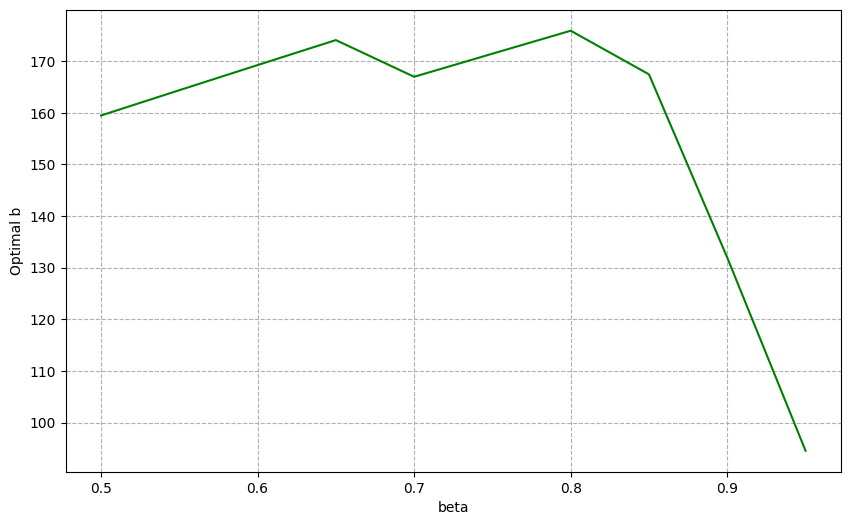

In [ ]:
# Constants and parameters
distribution_choice = 'normal'
beta_e = 0.9
gamma = 0.9
R = 1.05
y_lower = 800
y_upper = 4800
y_3 = 1300
y_1 = 1100
y_mode = 2800 # triangular
y_mean = 1300 # normal
sigma = 10000 # normal

b_num_points = 100
lim = 100


# Beta_p range
beta_p_values = np.arange(0.5, 1, 0.05)
max_b_p_values = []

# Calculate max_b_p for each beta_p
for beta_p in beta_p_values:
    result = calculate_parameters_p(distribution_choice, beta_e, beta_p, gamma, R, y_lower, y_upper, y_3, y_1, y_mode, y_mean, sigma, b_num_points, lim)
    max_b_p_values.append(result['max_b_p'])

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(beta_p_values, max_b_p_values, linestyle='-', color='green')
#plt.title('Maximum b_p as a function of beta_p')
plt.xlabel('beta')
plt.ylabel('Optimal b')
plt.grid(True, linestyle='--')
plt.show()

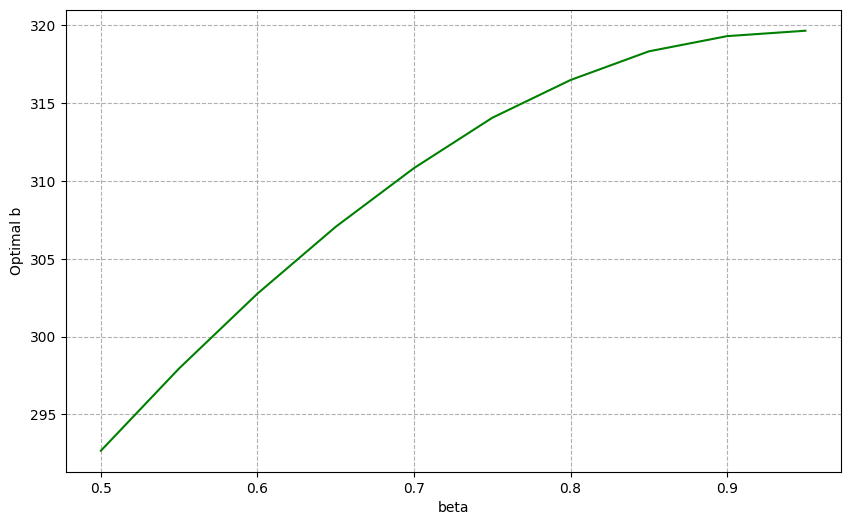

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(beta_p_values, max_b_p_values, linestyle='-', color='green')
#plt.title('Maximum b_p as a function of beta_p')
plt.xlabel('beta')
plt.ylabel('Optimal b')
plt.grid(True, linestyle='--')
plt.savefig('optimal_b_gamma_09.png')
plt.show()
files.download('optimal_b_gamma_09.png')

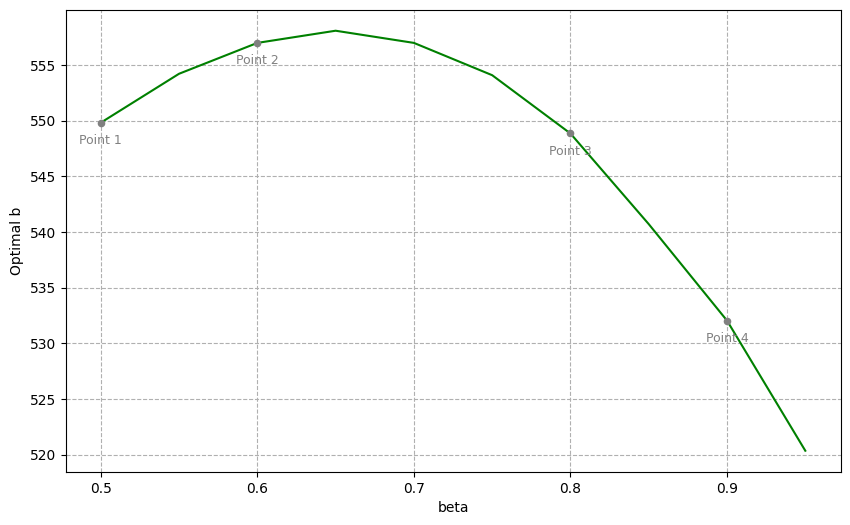

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(beta_p_values, max_b_p_values, linestyle='-', color='green')
#plt.title('Maximum b_p as a function of beta_p')
plt.xlabel('beta')
plt.ylabel('Optimal b')
plt.grid(True, linestyle='--')
idx_1 = (np.abs(beta_p_values - 0.5)).argmin()
idx_2 = (np.abs(beta_p_values - 0.6)).argmin()
idx_3 = (np.abs(beta_p_values - 0.8)).argmin()
idx_4 = (np.abs(beta_p_values - 0.9)).argmin()
plt.scatter(beta_p_values[idx_1], max_b_p_values[idx_1], color='grey', zorder=2, s=20)  # Mark the point
plt.scatter(beta_p_values[idx_2], max_b_p_values[idx_2], color='grey', zorder=2, s=20)
plt.scatter(beta_p_values[idx_3], max_b_p_values[idx_3], color='grey', zorder=2, s=20)
plt.scatter(beta_p_values[idx_4], max_b_p_values[idx_4], color='grey', zorder=2, s=20)
offset = 1  # Adjust this value to increase or decrease the gap
plt.text(beta_p_values[idx_1], max_b_p_values[idx_1] - offset, 'Point 1', color='grey', verticalalignment='top', horizontalalignment='center', fontsize=9)
plt.text(beta_p_values[idx_2], max_b_p_values[idx_2] - offset, 'Point 2', color='grey', verticalalignment='top', horizontalalignment='center', fontsize=9)
plt.text(beta_p_values[idx_3], max_b_p_values[idx_3] - offset, 'Point 3', color='grey', verticalalignment='top', horizontalalignment='center', fontsize=9)
plt.text(beta_p_values[idx_4], max_b_p_values[idx_4] - offset, 'Point 4', color='grey', verticalalignment='top', horizontalalignment='center', fontsize=9)
plt.savefig('optimal_b_gamma_08.png')
plt.show()
files.download('optimal_b_gamma_08.png')

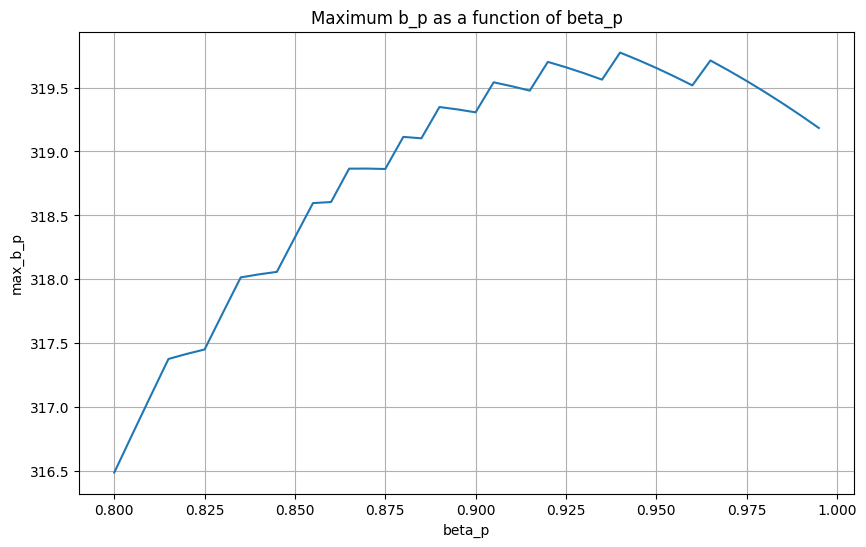

In [ ]:
# Constants and parameters
distribution_choice = 'triangular'
beta_e = 0.9
gamma = 0.9
R = 1.05
y_lower = 800
y_upper = 4800
y_3 = 1300
y_1 = 1100
y_mode = 2800 # triangular
y_mean = 1300 # normal
sigma = 100000 # normal

b_num_points = 5000
lim = 1000


# Beta_p range
beta_p_values = np.arange(0.8, 1, 0.005)
max_b_p_values = []

# Calculate max_b_p for each beta_p
for beta_p in beta_p_values:
    result = calculate_parameters_p(distribution_choice, beta_e, beta_p, gamma, R, y_lower, y_upper, y_3, y_1, y_mode, y_mean, sigma, b_num_points, lim)
    max_b_p_values.append(result['max_b_p'])

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(beta_p_values, max_b_p_values, linestyle='-')
plt.title('Maximum b_p as a function of beta_p')
plt.xlabel('beta_p')
plt.ylabel('max_b_p')
plt.grid(True)
plt.show()

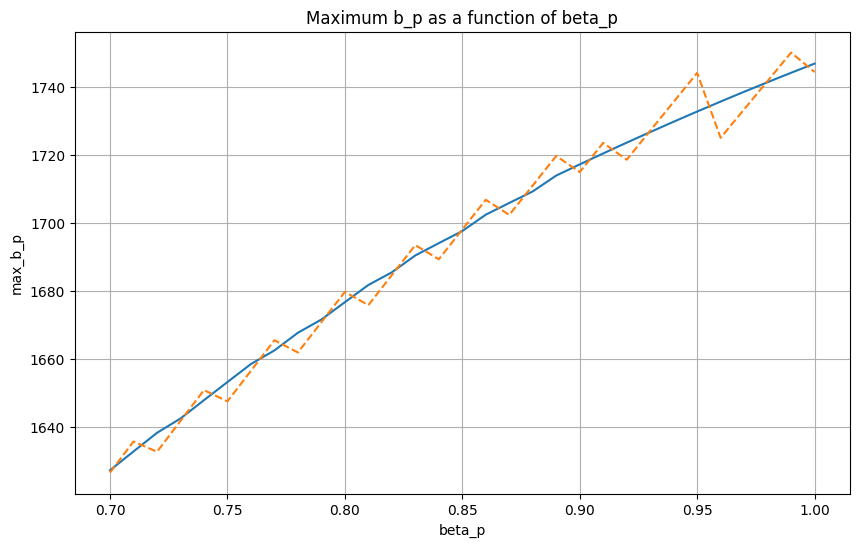

In [ ]:
# Constants and parameters
distribution_choice = 'triangular'
beta_e = 0.9
gamma = 0.95
R = 1.05
y_lower = 8000
y_upper = 48000
y_3 = 13000
y_1 = 11000
y_mode = 28000 # triangular
y_mean = 28000 # normal
sigma = 1000000 # normal

b_num_points_1 = 5000
lim_1 = 1000

# Beta_p range
beta_p_values = np.arange(0.7, 1, 0.01)
max_b_p_values_1 = []

# Calculate max_b_p for each beta_p
for beta_p in beta_p_values:
    result = calculate_parameters_p(distribution_choice, beta_e, beta_p, gamma, R, y_lower, y_upper, y_3, y_1, y_mode, y_mean, sigma, b_num_points_1, lim_1)
    max_b_p_values_1.append(result['max_b_p'])

b_num_points_2 = 500
lim_2 = 100

# Beta_p range
beta_p_values = np.arange(0.7, 1, 0.01)
max_b_p_values_2 = []

# Calculate max_b_p for each beta_p
for beta_p in beta_p_values:
    result = calculate_parameters_p(distribution_choice, beta_e, beta_p, gamma, R, y_lower, y_upper, y_3, y_1, y_mode, y_mean, sigma, b_num_points_2, lim_2)
    max_b_p_values_2.append(result['max_b_p'])

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(beta_p_values, max_b_p_values_1, linestyle='-')
plt.plot(beta_p_values, max_b_p_values_2, linestyle='--')
plt.title('Maximum b_p as a function of beta_p')
plt.xlabel('beta_p')
plt.ylabel('max_b_p')
plt.grid(True)
plt.show()

<ipython-input-30-028159def5d4>:80: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  integral_case_2_1, _ = quad(integrand_case_2_1, max(y_tau, b), y_upper, limit=lim)  # Ensure y_2 > b
<ipython-input-30-028159def5d4>:81: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  integral_case_2_2, _ = quad(integrand_case_2_2, y_lower, y_tau, limit=lim)


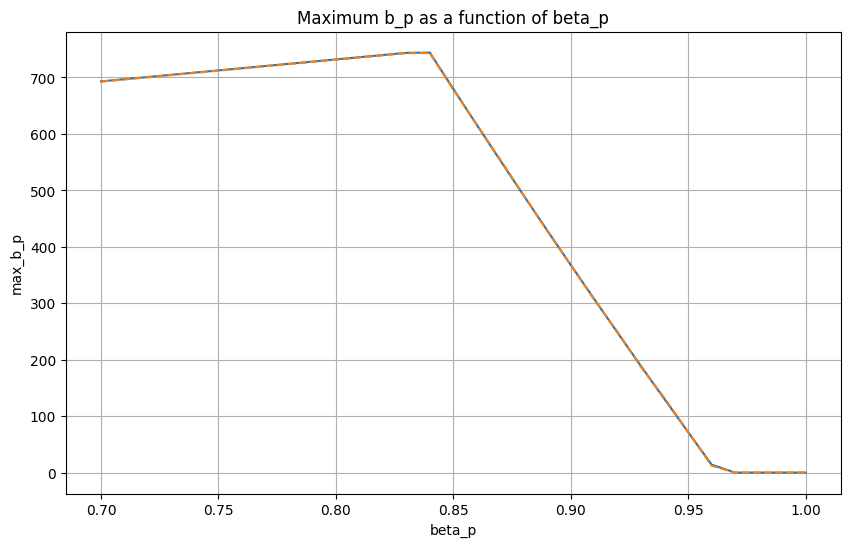

In [ ]:
# Constants and parameters
distribution_choice = 'uniform'
beta_e = 0.9
gamma = 0.95
R = 1.18
y_lower = 8300
y_upper = 14000
y_3 = 5200
y_1 = 9600
y_mode = 28000 # triangular
y_mean = 28000 # normal
sigma = 1000000 # normal

b_num_points_1 = 5000
lim_1 = 1000

# Beta_p range
beta_p_values = np.arange(0.7, 1, 0.01)
max_b_p_values_1 = []

# Calculate max_b_p for each beta_p
for beta_p in beta_p_values:
    result = calculate_parameters_p(distribution_choice, beta_e, beta_p, gamma, R, y_lower, y_upper, y_3, y_1, y_mode, y_mean, sigma, b_num_points_1, lim_1)
    max_b_p_values_1.append(result['max_b_p'])

b_num_points_2 = 500
lim_2 = 100

# Beta_p range
beta_p_values = np.arange(0.7, 1, 0.01)
max_b_p_values_2 = []

# Calculate max_b_p for each beta_p
for beta_p in beta_p_values:
    result = calculate_parameters_p(distribution_choice, beta_e, beta_p, gamma, R, y_lower, y_upper, y_3, y_1, y_mode, y_mean, sigma, b_num_points_2, lim_2)
    max_b_p_values_2.append(result['max_b_p'])

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(beta_p_values, max_b_p_values_1, linestyle='-')
plt.plot(beta_p_values, max_b_p_values_2, linestyle='--')
plt.title('Maximum b_p as a function of beta_p')
plt.xlabel('beta_p')
plt.ylabel('max_b_p')
plt.grid(True)
plt.show()

# plot U over b

In [ ]:
distribution_choice = 'normal'
beta_e = 0.9
beta_p_1 = 0.5
beta_p_2 = 0.9
gamma = 0.5
R = 1.05
y_lower = 800
y_upper = 4800
y_3 = 1300
y_1 = 1100
y_mode = 2800 # triangular
y_mean = 1300
sigma = 100000 # normal

b_num_points_1 = 500
lim_1 = 300

def calculate_parameters_p(distribution_choice, beta_e, beta_p, gamma, R, y_lower, y_upper, y_3, y_1, y_mode, y_mean, sigma,b_num_points,lim):
    #b_num_points = 1000
    sigma = np.sqrt(sigma) # normal
    psi = np.log(y_3) - np.log(gamma * y_3)
    b_upper_p = (1 - gamma * np.exp(- beta_p * psi)) * y_upper
    b_lower_p = (1 - gamma * np.exp(- beta_p * psi)) * y_lower

    # Different distributions, PDF, and CDF
    uniform_pdf = lambda y: 1 / (y_upper - y_lower) if y_lower <= y <= y_upper else 0

    def normal_pdf(y):
        normalization_constant = norm.cdf(y_upper, y_mean, sigma) - norm.cdf(y_lower, y_mean, sigma)

        if y_lower <= y <= y_upper:
            pdf_at_y = norm.pdf(y, y_mean, sigma)
            truncated_pdf = pdf_at_y / normalization_constant
            return truncated_pdf
        else:
            return 0

    def triangular_pdf(y):
        if y_lower <= y <= y_mode:
            return 2 * (y - y_lower) / ((y_upper - y_lower) * (y_mode - y_lower))
        elif y_mode < y <= y_upper:
            return 2 * (y_upper - y) / ((y_upper - y_lower) * (y_upper - y_mode))
        else:
            return 0

    def normal_cdf(y):
        cdf_at_y = norm.cdf(y, y_mean, sigma)
        cdf_at_y_lower = norm.cdf(y_lower, y_mean, sigma)
        cdf_at_y_upper = norm.cdf(y_upper, y_mean, sigma)
        if y < y_lower:
            return 0
        elif y > y_upper:
            return 1
        else:
            return (cdf_at_y - cdf_at_y_lower) / (cdf_at_y_upper - cdf_at_y_lower)

    def uniform_cdf(y):
        if y < y_lower:
            return 0
        elif y_lower <= y <= y_upper:
            return (y - y_lower) / (y_upper - y_lower)
        else:
            return 1

    def triangular_cdf(y):
        if y < y_lower:
            return 0
        elif y_lower <= y < y_mode:
            return ((y - y_lower)**2) / ((y_upper - y_lower) * (y_mode - y_lower))
        elif y_mode <= y <= y_upper:
            return 1 - ((y_upper - y)**2) / ((y_upper - y_lower) * (y_upper - y_mode))
        else:
            return 1

    c = 0.001
    def modify_triangular_pdf(y):
        # Original triangular PDF without the shift
        if y_lower <= y <= y_mode:
            original_pdf = 2 * (y - y_lower) / ((y_upper - y_lower) * (y_mode - y_lower))
        elif y_mode < y <= y_upper:
            original_pdf = 2 * (y_upper - y) / ((y_upper - y_lower) * (y_upper - y_mode))
        else:
            original_pdf = 0
        width = y_upper - y_lower
        area_under_original_pdf = 1
        area_added_by_c = c * width
        total_area = area_under_original_pdf + area_added_by_c
        normalization_factor = 1 / total_area
        shifted_pdf = (original_pdf + c) * normalization_factor
        return shifted_pdf

    def modify_triangular_cdf(y):
        width = y_upper - y_lower
        area_under_original_pdf = 1
        area_added_by_c = c * width
        total_area = area_under_original_pdf + area_added_by_c
        normalization_factor = 1 / total_area

        if y < y_lower:
            return 0
        elif y > y_upper:
            return 1
        else:
            integral = 0
            if y_lower <= y <= y_mode:
                integral += ((y - y_lower)**2) / ((y_upper - y_lower) * (y_mode - y_lower))
                integral += c * (y - y_lower)
            elif y_mode < y <= y_upper:
                integral += ((y_mode - y_lower)**2) / ((y_upper - y_lower) * (y_mode - y_lower))
                integral += c * (y_mode - y_lower)
                integral += ((y_upper - y_mode)**2 - (y_upper - y)**2) / ((y_upper - y_lower) * (y_upper - y_mode))
                integral += c * (y - y_mode)

            cdf_value = normalization_factor * integral
            return cdf_value


    if distribution_choice == 'triangular':
        chosen_cdf = triangular_cdf
        chosen_pdf = triangular_pdf
    elif distribution_choice == 'uniform':
        chosen_cdf = uniform_cdf
        chosen_pdf = uniform_pdf
    elif distribution_choice == 'normal':
        chosen_cdf = normal_cdf
        chosen_pdf = normal_pdf
    elif distribution_choice == 'modify_triangular':
        chosen_cdf = modify_triangular_cdf
        chosen_pdf = modify_triangular_pdf

    # caclulating U_p
    def Total_U_p(b, cdf, pdf):
        y_tau = b / (1 - gamma * np.exp(-beta_p * psi))
        cdf_value = cdf(y_tau)
        q_p = (1 / R) * (1 - cdf_value)
        integral_case_1 = 0
        if b < y_lower:
            integral_case_1, _ = quad(lambda y_2: np.log(y_2 - b) * pdf(y_2), y_lower, y_upper, limit=lim)
        def integrand_case_2_1(y_2):
            return np.log(y_2 - b) * pdf(y_2) if y_2 > b else 0  # Add conditional to handle y_2 <= b
        def integrand_case_2_2(y_2):
            return np.log(gamma * y_2) * pdf(y_2)
        integral_case_2_1, _ = quad(integrand_case_2_1, max(y_tau, b), y_upper, limit=lim)  # Ensure y_2 > b
        integral_case_2_2, _ = quad(integrand_case_2_2, y_lower, y_tau, limit=lim)
        integral_case_3, _ = quad(lambda y_2: np.log(gamma * y_2) * pdf(y_2), y_lower, y_upper, limit=lim)
        U_period_1 = np.log(y_1 + q_p * b)
        U_period_2 = ((1 if y_lower < y_tau < y_upper else 0) *
                      (beta_p * integral_case_2_1 + beta_p * integral_case_2_2) +
                      (1 if y_tau <= y_lower else 0) * (beta_p * integral_case_1) +  # Use <= to include equality
                      (1 if y_tau > y_upper else 0) * (beta_p * integral_case_3))
        U_period_3 = ((beta_p ** 2) * np.log(y_3) * (1 - cdf_value) +
                      (beta_p ** 2) * np.log(gamma * y_3) * cdf_value)
        U_total = U_period_1 + U_period_2 + U_period_3
        return U_total

    b_values = np.linspace(0, 1.5 * b_upper_p, b_num_points)
    U_values_uniform_p = []

    for b in b_values:
        U_uniform_p = Total_U_p(b, chosen_cdf, chosen_pdf)
        U_values_uniform_p.append(U_uniform_p)

    max_index_uniform_p = np.argmax(U_values_uniform_p)
    max_b_uniform_p = b_values[max_index_uniform_p]


    return pd.DataFrame({
        "U": U_values_uniform_p,
        "b": b_values
    })



results_1 = calculate_parameters_p(distribution_choice, beta_e, beta_p_1, gamma, R, y_lower, y_upper, y_3, y_1, y_mode, y_mean, sigma, b_num_points_1, lim_1)
#results_2 = calculate_parameters_p(distribution_choice, beta_e, beta_p_2, gamma, R, y_lower, y_upper, y_3, y_1, y_mode, y_mean, sigma, b_num_points_1, lim_1)

max_index_uniform_p_1 = np.argmax(results_1['U'])
max_b_uniform_p_1 = results_1['b'][max_index_uniform_p_1]

#max_index_uniform_p_2 = np.argmax(results_2['U'])
#max_b_uniform_p_2 = results_2['b'][max_index_uniform_p_2]


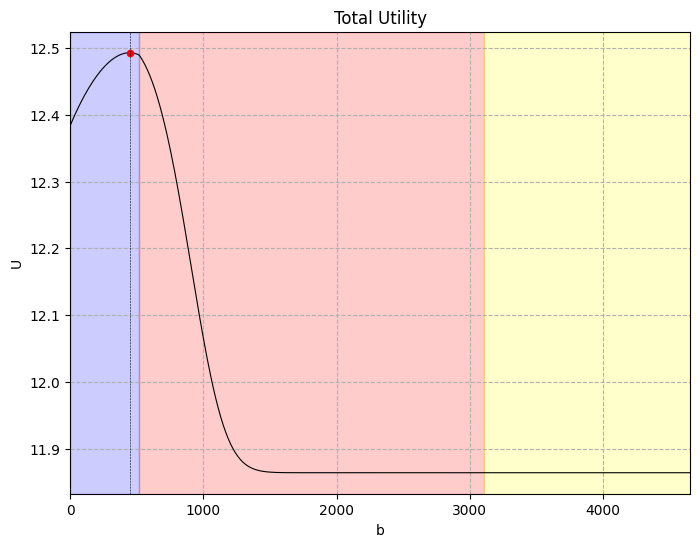

In [ ]:
from google.colab import files
psi = np.log(y_3) - np.log(gamma * y_3)
b_upper_p_1 = (1 - gamma * np.exp(- beta_p_1 * psi)) * y_upper
b_lower_p_1 = (1 - gamma * np.exp(- beta_p_1 * psi)) * y_lower

plt.figure(figsize=(8, 6))
plt.plot(results_1['b'], results_1['U'], alpha=1, color='black', linewidth=0.8)
plt.title('Total Utility')
plt.xlabel('b')
plt.ylabel('U')
#plt.xlim(100, 150)
#plt.ylim(14.375, 14.405)
plt.xlim(0, 1.5*b_upper_p_1)
plt.grid(True, linestyle='--')
plt.scatter(max_b_uniform_p_1, results_1['U'][max_index_uniform_p_1], color='red', zorder=2, s=20)
plt.axvline(x=max_b_uniform_p_1, color='black', linestyle='--', linewidth=0.4)
#plt.text(max_b_uniform_p_1, min(results_1['U']), f'b_optimal = {max_b_uniform_p_1:.2f}', verticalalignment='bottom', horizontalalignment='left', rotation=0, color='black', fontsize=11)
plt.axvspan(0, b_lower_p_1, color='blue', alpha=0.2)
plt.axvspan(b_lower_p_1, b_upper_p_1, color='red', alpha=0.2)
plt.axvspan(b_upper_p_1, 1.5*b_upper_p_1, color='yellow', alpha=0.2)
#plt.savefig('gamma_09_beta_095.png')
plt.show()
#files.download('gamma_09_beta_095.png')

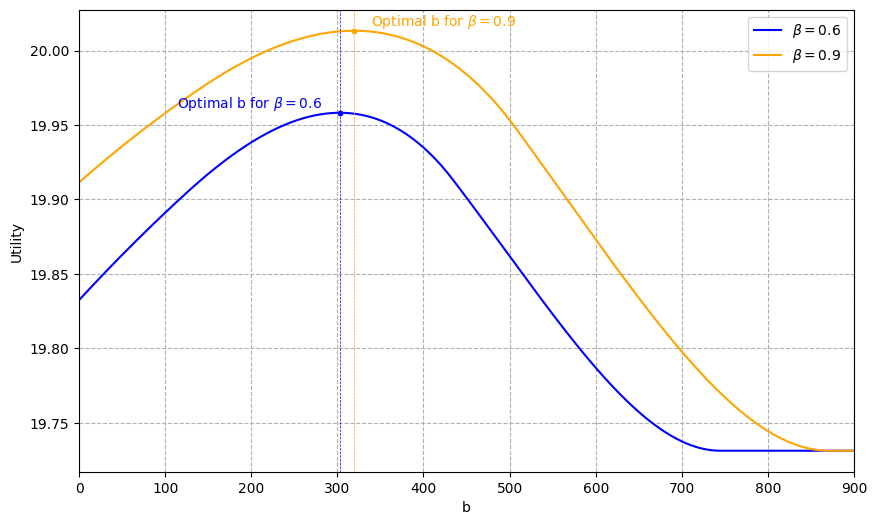

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example x-value where we want to calculate the difference
x_target = 2000

# Assuming results_1['b'] and results_2['b'] contain continuous numerical data similar to an index,
# We need to find the point closest to x_target in both datasets
idx_closest_blue = (np.abs(results_1['b'] - x_target)).idxmin()
idx_closest_orange = (np.abs(results_2['b'] - x_target)).idxmin()

# Calculate the difference in y-values at these points
y_diff = results_2['U'][idx_closest_orange] - results_1['U'][idx_closest_blue]

# Add this difference to all y-values of the blue dataset
results_1_adjusted = results_1['U'] + y_diff

# Plotting the adjusted results
plt.figure(figsize=(10, 6))
plt.plot(results_1['b'], results_1_adjusted, label='$\\beta =0.6$', color='blue', linestyle='-')
plt.plot(results_2['b'], results_2['U'], label='$\\beta =0.9$', color='orange')

# Scatter plot points with smaller size (e.g., s=50)
plt.scatter(results_1['b'][max_index_uniform_p_1], results_1_adjusted[max_index_uniform_p_1], color='blue', s=10, zorder=5)
plt.scatter(results_2['b'][max_index_uniform_p_2], results_2['U'][max_index_uniform_p_2], color='orange', s=10, zorder=5)

# Vertical lines at the points of max_b
plt.axvline(x=max_b_uniform_p_1, color='blue', linestyle='--', linewidth=0.5)
plt.axvline(x=max_b_uniform_p_2, color='orange', linestyle='--', linewidth=0.5)
x_text_offset = 20  # Adjust this value based on your x-axis scale to position the text
plt.text(results_1['b'][max_index_uniform_p_1] - x_text_offset, results_1_adjusted[max_index_uniform_p_1], 'Optimal b for $\\beta =0.6$', color='blue', verticalalignment='bottom', horizontalalignment='right')
plt.text(results_2['b'][max_index_uniform_p_2] + x_text_offset, results_2['U'][max_index_uniform_p_2], 'Optimal b for $\\beta =0.9$', color='orange', verticalalignment='bottom', horizontalalignment='left')
# Labeling and aesthetics
#plt.title('Utility vs. b (Adjusted)')
plt.xlabel('b')
plt.ylabel('Utility')
plt.xlim(0, 900)
plt.legend()
plt.grid(True, linestyle='--')
plt.savefig('u_beta_06_09.png')
plt.show()
files.download('u_beta_06_09.png')

In [ ]:
y_diff

5.073532483370517

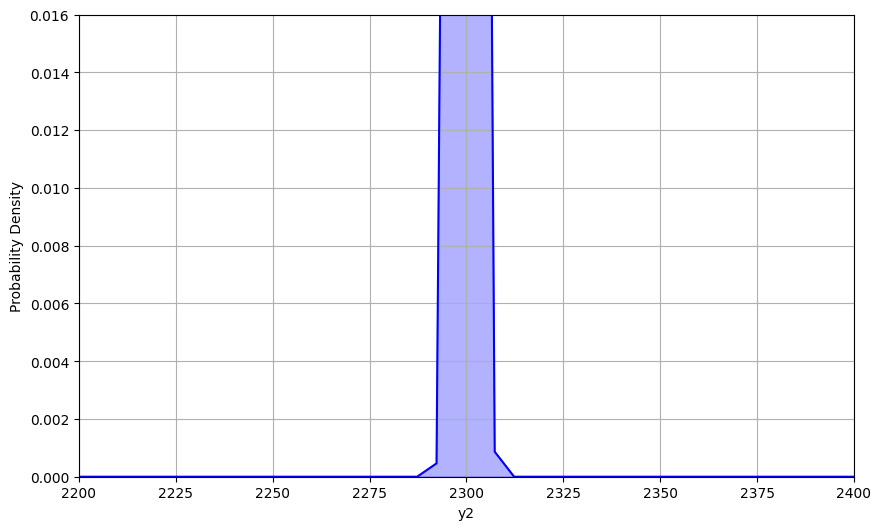

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm

def truncated_lognormal_pdf(y, mu, sigma, y_lower, y_upper):
    pdf_at_y = lognorm.pdf(y, s=sigma, scale=np.exp(mu))
    return pdf_at_y

# Convert mean and variance to the log scale parameters
y_mean = 2300  # Mean on the original scale
sigma_original = 5  # Variance on the original scale
sigma = np.sqrt(np.log(1 + sigma_original / y_mean**2))
mu = np.log(y_mean**2 / np.sqrt(sigma_original + y_mean**2))

y_lower = 0
y_upper = 5000

# Generate values for y across the specified range
y_values = np.linspace(y_lower, y_upper, 1000)
pdf_values = [truncated_lognormal_pdf(y, mu, sigma, y_lower, y_upper) for y in y_values]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(y_values, pdf_values, label='Truncated Lognormal PDF', color='blue')
plt.fill_between(y_values, pdf_values, color='blue', alpha=0.3)
#plt.title('Probability Density Function of Truncated Lognormal Distribution')
plt.xlabel('y2')
plt.ylabel('Probability Density')
#plt.legend()
plt.grid(True)
plt.xlim(2200,2400)
plt.ylim(0,0.016)
#plt.savefig('y2_lognormal.png')
plt.show()
#files.download('y2_lognormal.png')


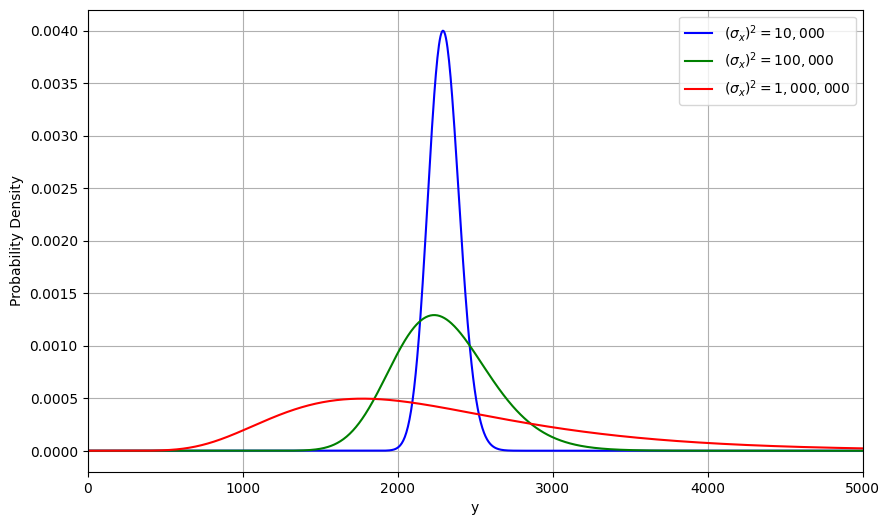

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm

def truncated_lognormal_pdf(y, mu, sigma, y_lower, y_upper):
    pdf_at_y = lognorm.pdf(y, s=sigma, scale=np.exp(mu))
    return pdf_at_y

def calculate_lognorm_parameters(y_mean, sigma_original):
    sigma = np.sqrt(np.log(1 + sigma_original / y_mean**2))
    mu = np.log(y_mean**2 / np.sqrt(sigma_original + y_mean**2))
    return mu, sigma

y_mean = 2300  # Mean on the original scale
y_lower = 0
y_upper = 5000
y_values = np.linspace(y_lower, y_upper, 1000)

# Variance settings
sigma_original_values = [10000, 100000, 1000000]

# Plotting setup
plt.figure(figsize=(10, 6))
colors = ['blue', 'green', 'red']  # Different colors for different variances
labels = [
    r'$(\sigma_x)^2 = 10,000$',
    r'$(\sigma_x)^2 = 100,000$',
    r'$(\sigma_x)^2 = 1,000,000$'
]

# Generate and plot PDFs for each sigma_original
for sigma_original, color, label in zip(sigma_original_values, colors, labels):
    mu, sigma = calculate_lognorm_parameters(y_mean, sigma_original)
    pdf_values = [truncated_lognormal_pdf(y, mu, sigma, y_lower, y_upper) for y in y_values]
    plt.plot(y_values, pdf_values, label=label, color=color)

plt.xlabel('y')
plt.ylabel('Probability Density')
plt.grid(True)
plt.xlim(0, 5000)
#plt.ylim(0, 0.0014)
plt.legend()

plt.savefig('y2_lognormal_comparison.png')
plt.show()

try:
    from google.colab import files
    files.download('y2_lognormal_comparison.png')  # Uncomment this in environments that support this operation
except ImportError:
    print("File download not supported in this environment. Please manually save the figure if needed.")


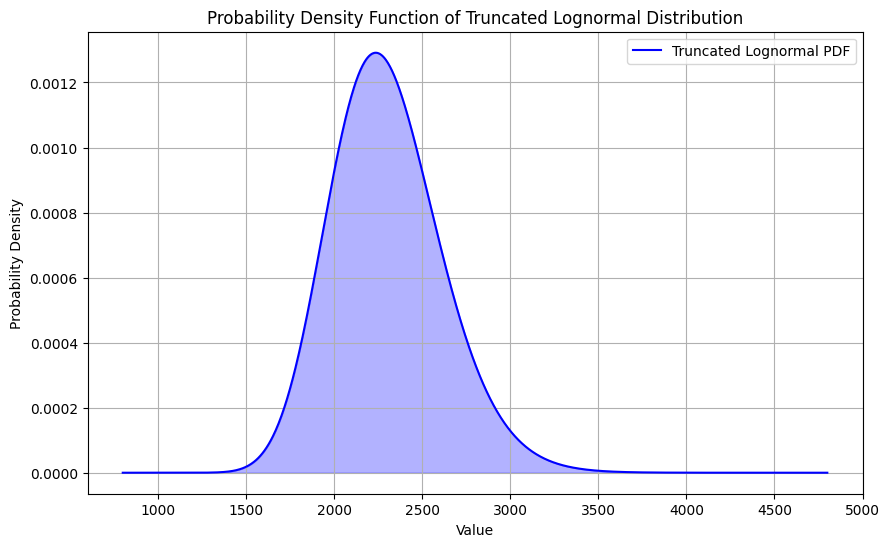

Mean of the truncated distribution: 2299.9999320455536
Mode of the truncated distribution: 2236.2903898286977


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm
from scipy.optimize import minimize_scalar

def truncated_lognormal_pdf(y, mu, sigma, y_lower, y_upper):
    if y_lower <= y <= y_upper:
        normalization_constant = lognorm.cdf(y_upper, s=sigma, scale=np.exp(mu)) - lognorm.cdf(y_lower, s=sigma, scale=np.exp(mu))
        pdf_at_y = lognorm.pdf(y, s=sigma, scale=np.exp(mu))
        truncated_pdf = pdf_at_y / normalization_constant
        return truncated_pdf
    else:
        return 0

# Convert mean and variance to the log scale parameters
y_mean = 2300  # Mean on the original scale
sigma_original = 100000  # Variance on the original scale
sigma = np.sqrt(np.log(1 + sigma_original / y_mean**2))
mu = np.log(y_mean**2 / np.sqrt(sigma_original + y_mean**2))

y_lower = 800
y_upper = 4800

# Generate values for y across the specified range
y_values = np.linspace(y_lower, y_upper, 1000)
pdf_values = [truncated_lognormal_pdf(y, mu, sigma, y_lower, y_upper) for y in y_values]

# Find the mode of the truncated distribution
mode_result = minimize_scalar(lambda y: -truncated_lognormal_pdf(y, mu, sigma, y_lower, y_upper), bounds=(y_lower, y_upper), method='bounded')
mode_value = mode_result.x

# Calculate the mean of the truncated distribution
mean_value = np.trapz(y_values * pdf_values, y_values)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(y_values, pdf_values, label='Truncated Lognormal PDF', color='blue')
plt.fill_between(y_values, pdf_values, color='blue', alpha=0.3)
plt.title('Probability Density Function of Truncated Lognormal Distribution')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()

# Output mean and mode
print(f"Mean of the truncated distribution: {mean_value}")
print(f"Mode of the truncated distribution: {mode_value}")


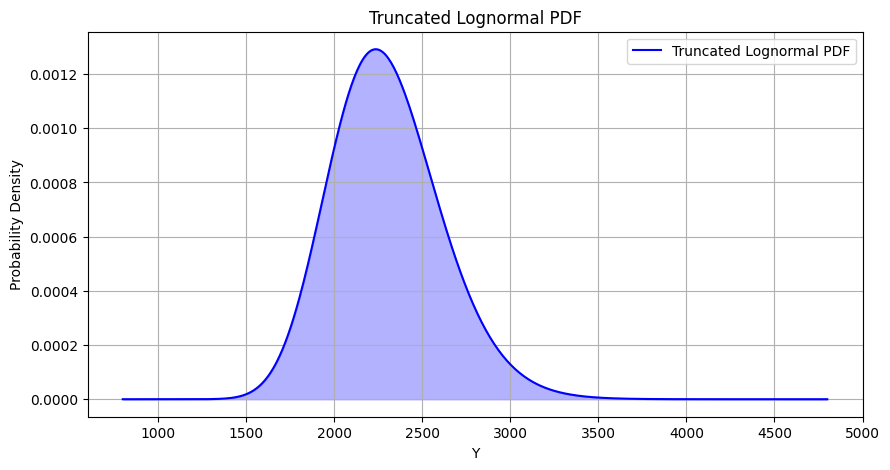

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm

# Constants for the lognormal distribution
mu = np.log(2300**2 / np.sqrt(100000 + 2300**2))  # Example: y_mean = 1300, sigma_original = 100000
sigma = np.sqrt(np.log(1 + 100000 / 2300**2))  # Convert variance to the standard deviation on the log scale

# Boundaries for the distribution
y_lower = 800
y_upper = 4800

def lognormal_pdf(y, mu, sigma, y_lower, y_upper):
    """Calculate the PDF of the truncated lognormal distribution for a given y."""
    if y_lower <= y <= y_upper:
        normalization_constant = lognorm.cdf(y_upper, s=sigma, scale=np.exp(mu)) - lognorm.cdf(y_lower, s=sigma, scale=np.exp(mu))
        pdf_at_y = lognorm.pdf(y, s=sigma, scale=np.exp(mu))
        truncated_pdf = pdf_at_y / normalization_constant
        return truncated_pdf
    else:
        return 0

# Generate y values within the bounds
y_values = np.linspace(y_lower, y_upper, 500)
pdf_values = [lognormal_pdf(y, mu, sigma, y_lower, y_upper) for y in y_values]

# Plotting the PDF
plt.figure(figsize=(10, 5))
plt.plot(y_values, pdf_values, label='Truncated Lognormal PDF', color='blue')
plt.fill_between(y_values, pdf_values, color='blue', alpha=0.3)
plt.title('Truncated Lognormal PDF')
plt.xlabel('Y')
plt.ylabel('Probability Density')
plt.grid(True)
plt.legend()
plt.show()


# Finding good params

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import lognorm
from scipy.integrate import quad
from scipy.optimize import minimize

def calculate_parameters_p_lognormal(beta_p, gamma, R, y_lower, y_upper, y_3, y_1, y_mean, sigma, b_num_points, lim):
    # Convert mean and variance to the log scale parameters
    mu = np.log(y_mean**2 / np.sqrt(sigma + y_mean**2))
    sigma = np.sqrt(np.log(1 + sigma / y_mean**2))  # Standard deviation on the log scale

    psi = np.log(y_3) - np.log(gamma * y_3)
    b_upper_p = (1 - gamma * np.exp(- beta_p * psi)) * y_upper
    b_lower_p = (1 - gamma * np.exp(- beta_p * psi)) * y_lower

    def lognormal_pdf(y):
        if y_lower <= y <= y_upper:
            normalization_constant = lognorm.cdf(y_upper, s=sigma, scale=np.exp(mu)) - lognorm.cdf(y_lower, s=sigma, scale=np.exp(mu))
            pdf_at_y = lognorm.pdf(y, s=sigma, scale=np.exp(mu))
            truncated_pdf = pdf_at_y / normalization_constant
            return truncated_pdf
        else:
            return 0

    def lognormal_cdf(y):
        cdf_at_y = lognorm.cdf(y, s=sigma, scale=np.exp(mu))
        cdf_at_y_lower = lognorm.cdf(y_lower, s=sigma, scale=np.exp(mu))
        cdf_at_y_upper = lognorm.cdf(y_upper, s=sigma, scale=np.exp(mu))
        if y < y_lower:
            return 0
        elif y > y_upper:
            return 1
        else:
            return (cdf_at_y - cdf_at_y_lower) / (cdf_at_y_upper - cdf_at_y_lower)

    def triangular_pdf(y):
        if y_lower <= y <= y_mode:
            return 2 * (y - y_lower) / ((y_upper - y_lower) * (y_mode - y_lower))
        elif y_mode < y <= y_upper:
            return 2 * (y_upper - y) / ((y_upper - y_lower) * (y_upper - y_mode))
        else:
            return 0

    def triangular_cdf(y):
        if y < y_lower:
            return 0
        elif y_lower <= y < y_mode:
            return ((y - y_lower)**2) / ((y_upper - y_lower) * (y_mode - y_lower))
        elif y_mode <= y <= y_upper:
            return 1 - ((y_upper - y)**2) / ((y_upper - y_lower) * (y_upper - y_mode))
        else:
            return 1

    def Total_U_p(b, cdf, pdf):
        y_tau = b / (1 - gamma * np.exp(-beta_p * psi))
        cdf_value = cdf(y_tau)
        q_p = (1 / R) * (1 - cdf_value)
        integral_case_1 = 0
        if b < y_lower:
            integral_case_1, _ = quad(lambda y_2: np.log(y_2 - b) * pdf(y_2), y_lower, y_upper, limit=lim)

        integral_case_2_1, _ = quad(lambda y_2: np.log(y_2 - b) * pdf(y_2) if y_2 > b else 0, max(y_tau, b), y_upper, limit=lim)
        integral_case_2_2, _ = quad(lambda y_2: np.log(gamma * y_2) * pdf(y_2), y_lower, y_tau, limit=lim)
        integral_case_3, _ = quad(lambda y_2: np.log(gamma * y_2) * pdf(y_2), y_lower, y_upper, limit=lim)

        U_period_1 = np.log(y_1 + q_p * b)
        U_period_2 = ((1 if y_lower < y_tau < y_upper else 0) * (beta_p * integral_case_2_1 + beta_p * integral_case_2_2) +
                      (1 if y_tau <= y_lower else 0) * (beta_p * integral_case_1) +
                      (1 if y_tau > y_upper else 0) * (beta_p * integral_case_3))
        U_period_3 = (beta_p ** 2) * np.log(y_3) * (1 - cdf_value) + (beta_p ** 2) * np.log(gamma * y_3) * cdf_value
        U_total = U_period_1 + U_period_2 + U_period_3
        return U_total

    b_values = np.linspace(0, 1.5 * b_upper_p, b_num_points)
    objective = lambda b: -Total_U_p(b, lognormal_cdf, lognormal_pdf)
    b_bounds = (0, b_upper_p)
    result = minimize(objective, x0=b_bounds[1] / 2, bounds=[b_bounds], method='TNC')
    max_b = result.x[0]
    y_tau_star = max_b / (1 - gamma * np.exp(-beta_p * psi))
    cdf_value_star = lognormal_cdf(y_tau_star)
    q_p_star = (1 / R) * (1 - cdf_value_star)

    return max_b, q_p_star, cdf_value_star

gamma = 0.6
beta_p = 0.8
R = 1.05
y_lower = 800
y_upper = 4800
y_3 = 1300
y_1 = 1100
y_mean = 2300
sigma = 10000  # This is variance on the original scale
b_num_points = 300
lim = 100

#max_b, q_p_star, cdf_value_star = calculate_parameters_p_lognormal(beta_p, gamma, R, y_lower, y_upper, y_3, y_1, y_mean, sigma, b_num_points, lim)

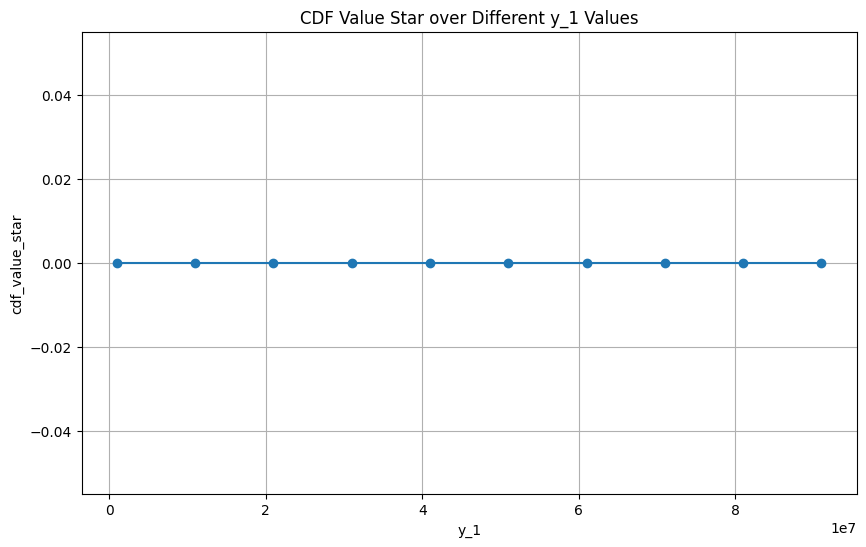

In [ ]:
gamma = 0.6
beta_p = 0.8
R = 1.05
y_lower = 800
y_upper = 4800
y_3 = 1300
y_1 = 1100
y_mean = 2300
#sigma = 10000000  # Variance
b_num_points = 200
lim = 100

y_1_values = np.arange(1000000, 100000000, 10000000)
cdf_values = []

for sigma in y_1_values:
    max_b, q_p_star, cdf_value_star = calculate_parameters_p_lognormal(beta_p, gamma, R, y_lower, y_upper, y_3, y_1, y_mean, sigma, b_num_points, lim)
    cdf_values.append(cdf_value_star)

plt.figure(figsize=(10, 6))
plt.plot(y_1_values, cdf_values, marker='o')
plt.xlabel('y_1')
plt.ylabel('cdf_value_star')
plt.title('CDF Value Star over Different y_1 Values')
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import lognorm
from scipy.integrate import quad
from scipy.optimize import minimize
from scipy.optimize import minimize, Bounds

def find_parameters(y_lower=800, y_upper=4800, y_mean=2300, b_num_points=300, lim=100):
    gamma = 0.6
    beta_p = 0.8
    R = 1.05
    options = {'maxiter': 1000, 'ftol': 1e-9, 'disp': True}  # Tighter convergence criteria and diagnostic output

    def objective(params):
        y_3, y_1, sigma = params
        _, _, cdf_value_star = calculate_parameters_p_lognormal(beta_p, gamma, R, y_lower, y_upper, y_3, y_1, y_mean, sigma, b_num_points, lim)
        return abs(cdf_value_star - 0.05)

    initial_guess = [1300, 1100, 10000]
    bounds = Bounds([500, 500, 10000], [3000, 3000, 1000000])

    result = minimize(objective, initial_guess, bounds=bounds, method='L-BFGS-B', options=options)
    optimal_y3, optimal_y1, optimal_sigma = result.x

    return optimal_y3, optimal_y1, optimal_sigma

# Run the optimization
optimal_y3, optimal_y1, optimal_sigma = find_parameters()
print("Optimal y_3:", optimal_y3)
print("Optimal y_1:", optimal_y1)
print("Optimal sigma:", optimal_sigma)


Optimal y_3: 1300.0
Optimal y_1: 1100.0
Optimal sigma: 10000.0


# lognormal

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import lognorm
from scipy.integrate import quad
from scipy.optimize import minimize

def calculate_parameters_p_lognormal(beta_p, gamma, R, y_lower, y_upper, y_3, y_1, y_mean, sigma, b_num_points, lim):
    # Convert mean and variance to the log scale parameters
    mu = np.log(y_mean**2 / np.sqrt(sigma + y_mean**2))
    sigma = np.sqrt(np.log(1 + sigma / y_mean**2))  # Standard deviation on the log scale

    psi = np.log(y_3) - np.log(gamma * y_3)
    b_upper_p = (1 - gamma * np.exp(- beta_p * psi)) * y_upper
    b_lower_p = (1 - gamma * np.exp(- beta_p * psi)) * y_lower

    def lognormal_pdf(y):
        if y_lower <= y <= y_upper:
            normalization_constant = lognorm.cdf(y_upper, s=sigma, scale=np.exp(mu)) - lognorm.cdf(y_lower, s=sigma, scale=np.exp(mu))
            pdf_at_y = lognorm.pdf(y, s=sigma, scale=np.exp(mu))
            truncated_pdf = pdf_at_y / normalization_constant
            return truncated_pdf
        else:
            return 0

    def lognormal_cdf(y):
        cdf_at_y = lognorm.cdf(y, s=sigma, scale=np.exp(mu))
        cdf_at_y_lower = lognorm.cdf(y_lower, s=sigma, scale=np.exp(mu))
        cdf_at_y_upper = lognorm.cdf(y_upper, s=sigma, scale=np.exp(mu))
        if y < y_lower:
            return 0
        elif y > y_upper:
            return 1
        else:
            return (cdf_at_y - cdf_at_y_lower) / (cdf_at_y_upper - cdf_at_y_lower)

    def triangular_pdf(y):
        if y_lower <= y <= y_mode:
            return 2 * (y - y_lower) / ((y_upper - y_lower) * (y_mode - y_lower))
        elif y_mode < y <= y_upper:
            return 2 * (y_upper - y) / ((y_upper - y_lower) * (y_upper - y_mode))
        else:
            return 0

    def triangular_cdf(y):
        if y < y_lower:
            return 0
        elif y_lower <= y < y_mode:
            return ((y - y_lower)**2) / ((y_upper - y_lower) * (y_mode - y_lower))
        elif y_mode <= y <= y_upper:
            return 1 - ((y_upper - y)**2) / ((y_upper - y_lower) * (y_upper - y_mode))
        else:
            return 1

    def Total_U_p(b, cdf, pdf):
        y_tau = b / (1 - gamma * np.exp(-beta_p * psi))
        cdf_value = cdf(y_tau)
        q_p = (1 / R) * (1 - cdf_value)
        integral_case_1 = 0
        if b < y_lower:
            integral_case_1, _ = quad(lambda y_2: np.log(y_2 - b) * pdf(y_2), y_lower, y_upper, limit=lim)

        integral_case_2_1, _ = quad(lambda y_2: np.log(y_2 - b) * pdf(y_2) if y_2 > b else 0, max(y_tau, b), y_upper, limit=lim)
        integral_case_2_2, _ = quad(lambda y_2: np.log(gamma * y_2) * pdf(y_2), y_lower, y_tau, limit=lim)
        integral_case_3, _ = quad(lambda y_2: np.log(gamma * y_2) * pdf(y_2), y_lower, y_upper, limit=lim)

        U_period_1 = np.log(y_1 + q_p * b)
        U_period_2 = ((1 if y_lower < y_tau < y_upper else 0) * (beta_p * integral_case_2_1 + beta_p * integral_case_2_2) +
                      (1 if y_tau <= y_lower else 0) * (beta_p * integral_case_1) +
                      (1 if y_tau > y_upper else 0) * (beta_p * integral_case_3))
        U_period_3 = (beta_p ** 2) * np.log(y_3) * (1 - cdf_value) + (beta_p ** 2) * np.log(gamma * y_3) * cdf_value
        U_total = U_period_1 + U_period_2 + U_period_3
        return U_total

    b_values = np.linspace(0, 1.5 * b_upper_p, b_num_points)
    objective = lambda b: -Total_U_p(b, lognormal_cdf, lognormal_pdf)
    b_bounds = (0, b_upper_p)
    result = minimize(objective, x0=b_bounds[1] / 2, bounds=[b_bounds], method='TNC')
    max_b = result.x[0]
    y_tau_star = max_b / (1 - gamma * np.exp(-beta_p * psi))
    cdf_value_star = lognormal_cdf(y_tau_star)
    q_p_star = (1 / R) * (1 - cdf_value_star)

    return max_b, q_p_star, cdf_value_star

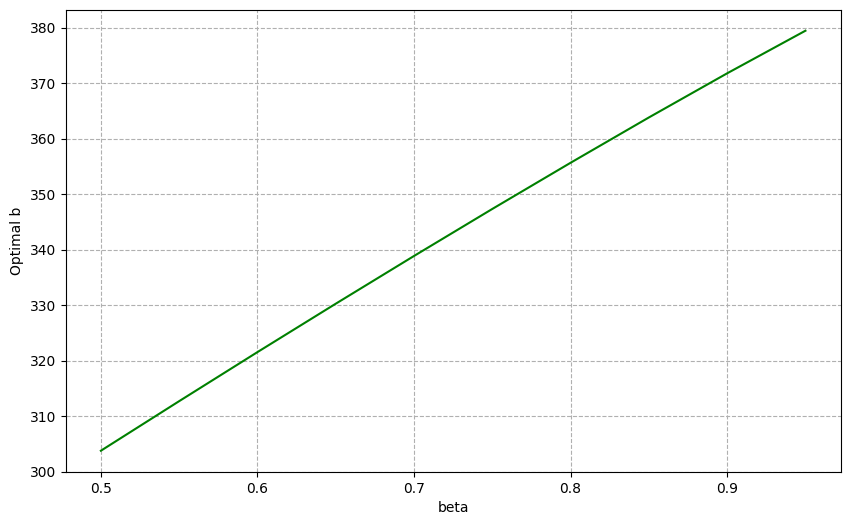

In [ ]:
gamma = 0.9
R = 1.05
y_lower = 800
y_upper = 4800
y_3 = 1300
y_1 = 1100
y_mean = 2300
sigma = 10000  # This is variance on the original scale
b_num_points = 300
lim = 100

# Beta_p range
beta_p_values = np.arange(0.5, 1, 0.05)
max_b_p_values = []
q_p_star_values = []
cdf_value_star_values = []

# Calculate max_b_p for each beta_p
for beta_p in beta_p_values:
    max_b, q_p_star, cdf_value_star = calculate_parameters_p_lognormal(beta_p, gamma, R, y_lower, y_upper, y_3, y_1, y_mean, sigma, b_num_points, lim)
    max_b_p_values.append(max_b)
    q_p_star_values.append(q_p_star)
    cdf_value_star_values.append(cdf_value_star)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(beta_p_values, max_b_p_values, linestyle='-', color='green')
#plt.title('Maximum b_p as a function of beta_p')
plt.xlabel('beta')
plt.ylabel('Optimal b')
plt.grid(True, linestyle='--')
#plt.savefig('optimal_b_gamma_09_lognormal.png')
plt.show()
#files.download('optimal_b_gamma_09_lognormal.png')

# optimal b and q(optimal b) vs. beta

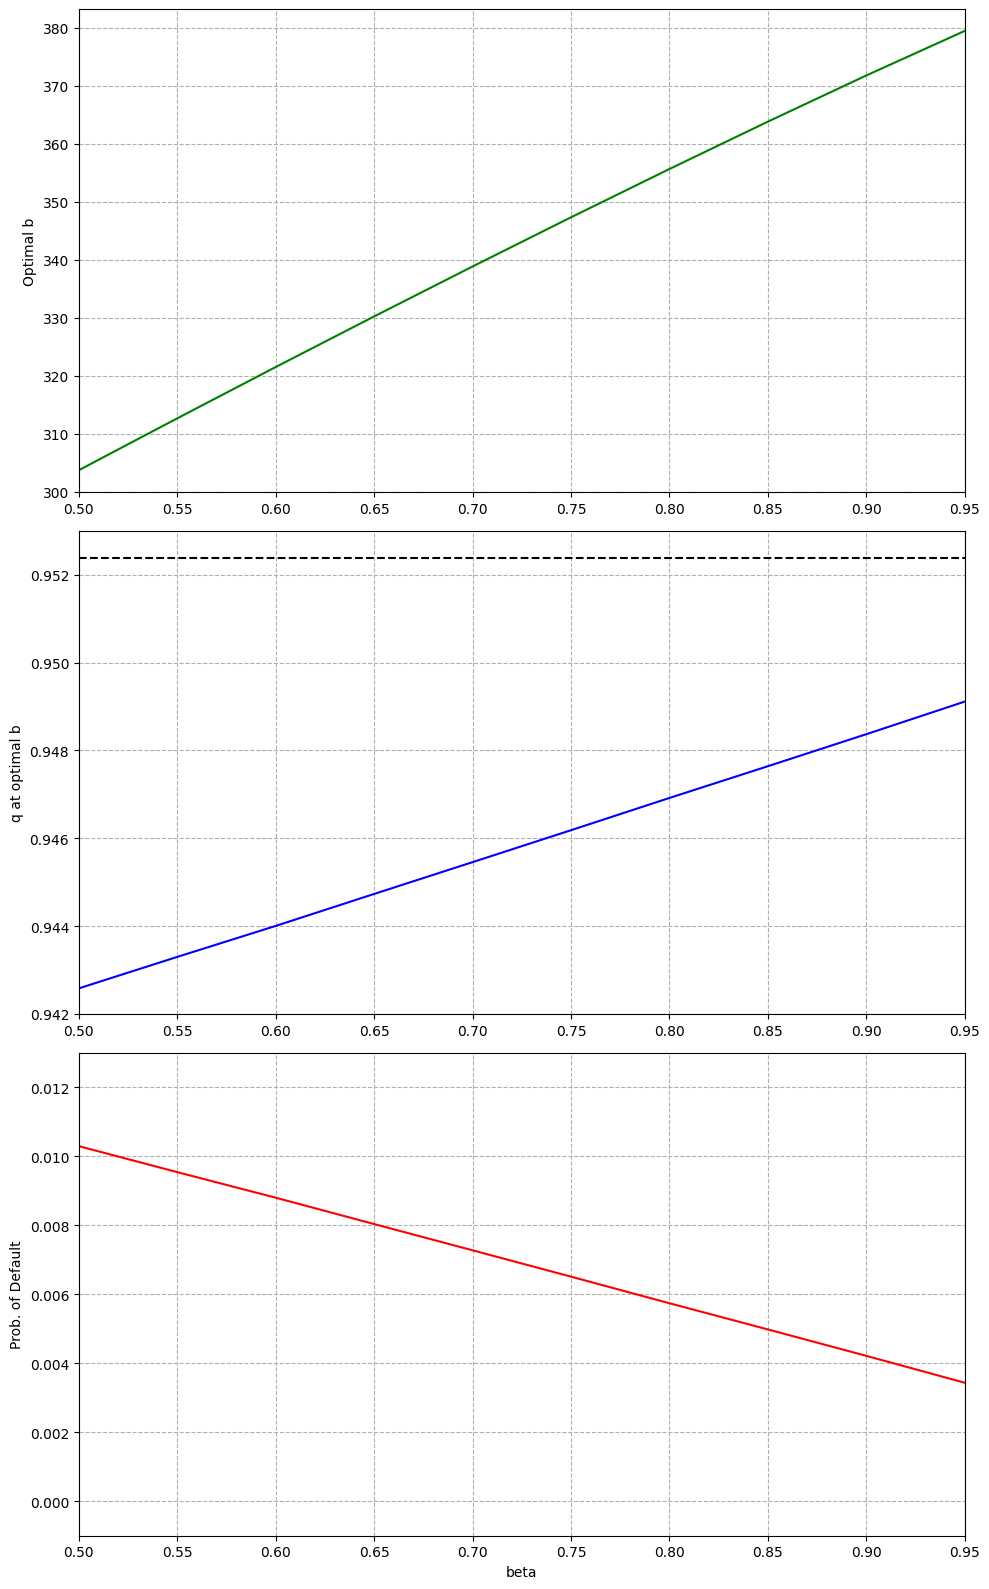

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import matplotlib.ticker as ticker
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 16))

# Plot for max_b_p_values against beta_p_values
ax1.plot(beta_p_values, max_b_p_values, linestyle='-', color='green')
#ax1.set_xlabel('beta')
ax1.set_ylabel('Optimal b')
ax1.grid(True, linestyle='--')
#ax1.set_title('Maximum b_p as a function of beta_p')
#ax1.set_ylim(580, 680)
ax1.set_xlim(0.5, 0.95)

# Plot for q_p_star_values against max_b_p_values
ax2.plot(beta_p_values, q_p_star_values, linestyle='-', color='blue')
#ax2.set_xlabel('beta')
ax2.set_ylabel('q at optimal b')
ax2.grid(True, linestyle='--')
#ax2.set_title('q_p_star as a function of Maximum b_p')
ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))  # Formatting y-axis
hline_value = 1/R
ax2.axhline(y=hline_value, color='black', linestyle='--')
#ax2.text(0.5, hline_value + 0.01, f'1/R = {hline_value:.3f}', color='red', ha='center')
ax2.set_ylim(0.942, 0.953)
ax2.set_xlim(0.5, 0.95)

ax3.plot(beta_p_values, cdf_value_star_values, linestyle='-', color='red')
ax3.set_xlabel('beta')
ax3.set_ylabel('Prob. of Default')
ax3.grid(True, linestyle='--')
#ax2.set_title('q_p_star as a function of Maximum b_p')
ax3.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))  # Formatting y-axis
ax3.set_ylim(-0.001, 0.013)
ax3.set_xlim(0.5, 0.95)

plt.tight_layout()
plt.savefig('combined.png')
plt.show()
files.download('combined.png')

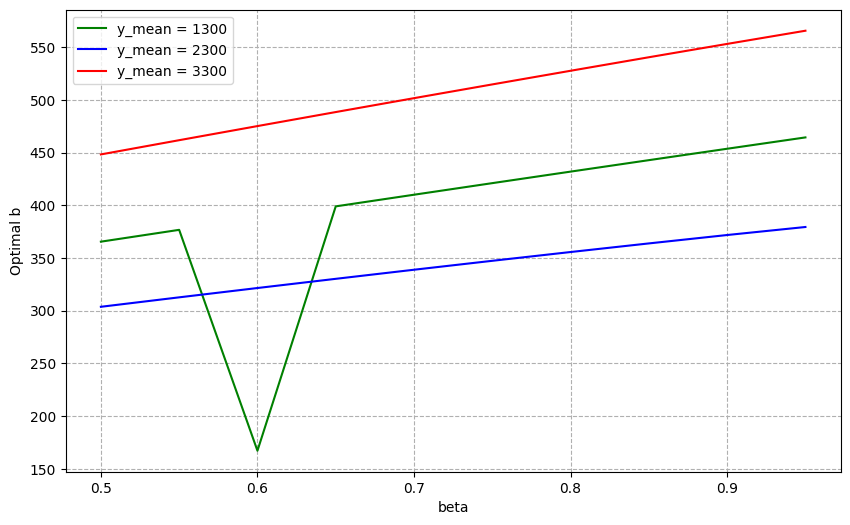

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming calculate_parameters_p_lognormal is a predefined function
# def calculate_parameters_p_lognormal(...):
#     # implementation here
#     return max_b

gamma = 0.9
R = 1.05
y_lower = 400
y_upper = 5000
#y_mean = 2300
sigma = 10000  # This is variance on the original scale
b_num_points = 300
lim = 100
y_3 = 1300
y_1 = 1100

# Beta_p range
beta_p_values = np.arange(0.5, 1, 0.05)

# Different y_1 values to plot
y_1_values = [1300, 2300, 3300]
colors = ['green', 'blue', 'red']  # Different colors for different lines

plt.figure(figsize=(10, 6))

# Loop over y_1 values
for i, y_mean in enumerate(y_1_values):
    max_b_p_values = []
    # Calculate max_b_p for each beta_p
    for beta_p in beta_p_values:
        max_b = calculate_parameters_p_lognormal(beta_p, gamma, R, y_lower, y_upper, y_3, y_1, y_mean, sigma, b_num_points, lim)
        max_b_p_values.append(max_b)

    # Plotting the results for the current y_1
    plt.plot(beta_p_values, max_b_p_values, linestyle='-', color=colors[i], label=f'y_mean = {y_mean}')

plt.xlabel('beta')
plt.ylabel('Optimal b')
plt.grid(True, linestyle='--')
plt.legend()
plt.savefig('y_mean.png')
plt.show()
files.download('y_mean.png')

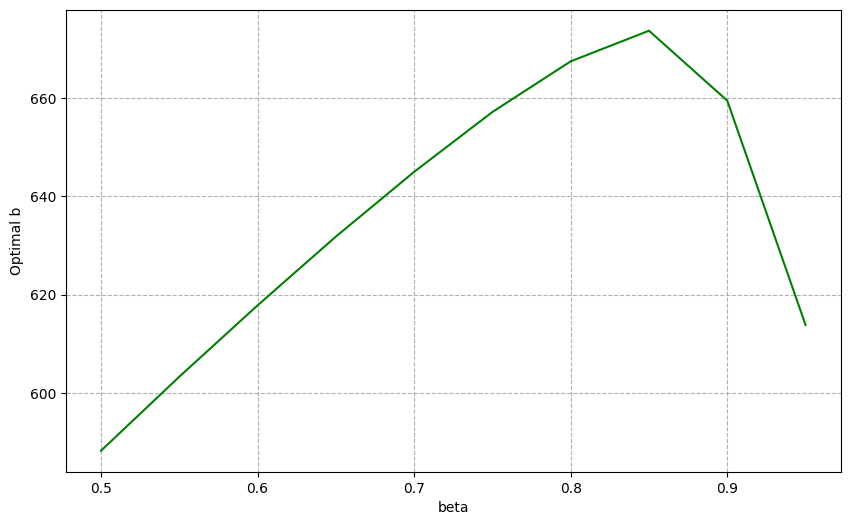

In [ ]:
# # Beta_p range
# beta_p_values = np.arange(0.5, 1, 0.05)
# max_b_p_values = []

# # Calculate max_b_p for each beta_p
# for beta_p in beta_p_values:
#     max_b = calculate_parameters_p_lognormal(beta_p, gamma, R, y_lower, y_upper, y_3, y_1, y_mean, sigma, b_num_points, lim)
#     max_b_p_values.append(max_b)

# # Plotting the results
# plt.figure(figsize=(10, 6))
# plt.plot(beta_p_values, max_b_p_values, linestyle='-', color='green')
# #plt.title('Maximum b_p as a function of beta_p')
# plt.xlabel('beta')
# plt.ylabel('Optimal b')
# plt.grid(True, linestyle='--')
# #plt.savefig('optimal_b_gamma_09_lognormal.png')
# plt.show()
# #files.download('optimal_b_gamma_09_lognormal.png')

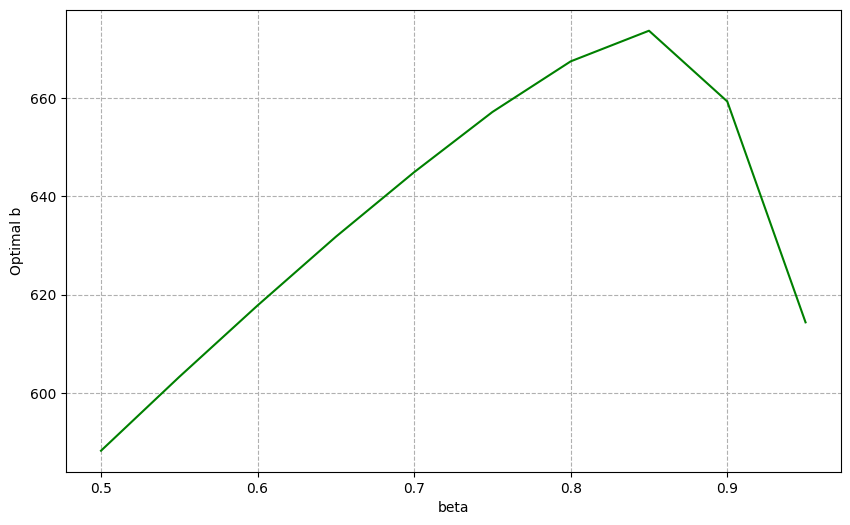

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# # Plotting the results
# plt.figure(figsize=(10, 6))
# plt.plot(beta_p_values, max_b_p_values, linestyle='-', color='green')
# #plt.title('Maximum b_p as a function of beta_p')
# plt.xlabel('beta')
# plt.ylabel('Optimal b')
# plt.grid(True, linestyle='--')
# plt.savefig('optimal_b_y1_lognormal.png')
# plt.show()
# files.download('optimal_b_y1_lognormal.png')

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import lognorm
from scipy.integrate import quad
def calculate_parameters_p_lognormal(beta_p, gamma, R, y_lower, y_upper, y_3, y_1, y_mean, sigma, b_num_points, lim):
    mu = np.log(y_mean**2 / np.sqrt(sigma + y_mean**2))
    sigma = np.sqrt(np.log(1 + sigma / y_mean**2))
    psi = np.log(y_3) - np.log(gamma * y_3)
    def lognormal_pdf(y):
        pdf_at_y = lognorm.pdf(y, s=sigma, scale=np.exp(mu))
        return pdf_at_y
    def lognormal_cdf(y):
        cdf_at_y = lognorm.cdf(y, s=sigma, scale=np.exp(mu))
        return cdf_at_y
    def Total_U_p(b, cdf, pdf):
        y_tau = b / (1 - gamma * np.exp(-beta_p * psi))
        cdf_value = cdf(y_tau)
        q_p = (1 / R) * (1 - cdf_value)
        integral_case_2_1, _ = quad(lambda y_2: np.log(y_2 - b) * pdf(y_2) if y_2 > b else 0, max(y_tau, b), y_upper, limit=lim)
        integral_case_2_2, _ = quad(lambda y_2: np.log(gamma * y_2) * pdf(y_2), y_lower, y_tau, limit=lim)
        U_period_1 = np.log(y_1 + q_p * b)
        U_period_2 = ((beta_p * integral_case_2_1 + beta_p * integral_case_2_2))
        U_period_3 = (beta_p ** 2) * np.log(y_3) * (1 - cdf_value) + (beta_p ** 2) * np.log(gamma * y_3) * cdf_value
        U_total = U_period_1 + U_period_2 + U_period_3
        return U_total

    def price(b, cdf, pdf):
        y_tau = b / (1 - gamma * np.exp(-beta_p * psi))
        cdf_value = cdf(y_tau)
        q_p = (1 / R) * (1 - cdf_value)
        return q_p

    b_values = np.linspace(0, y_upper, b_num_points)
    U_values_lognormal_p = [Total_U_p(b, lognormal_cdf, lognormal_pdf) for b in b_values]
    qb_values_lognormal_p = [b * price(b, lognormal_cdf, lognormal_pdf) for b in b_values]
    max_index_lognormal_p = np.argmax(U_values_lognormal_p)
    max_qb_index_lognormal_p = np.argmax(qb_values_lognormal_p)
    max_b_lognormal_p = b_values[max_index_lognormal_p]
    max_b_qb_lognormal_p = b_values[max_qb_index_lognormal_p]

    return pd.DataFrame({
        "U": U_values_lognormal_p,
        "b": b_values,
        "qb": qb_values_lognormal_p
    }), max_b_lognormal_p, max_b_qb_lognormal_p

# Configuration
gamma = 0.6
beta_p = 0.8
R = 1.05
y_lower = 1
y_upper = 4000
y_3 = 1300
y_1 = 1100
y_mean = 2300
sigma = 10000  # This is variance on the original scale
b_num_points = 1000
lim = 500


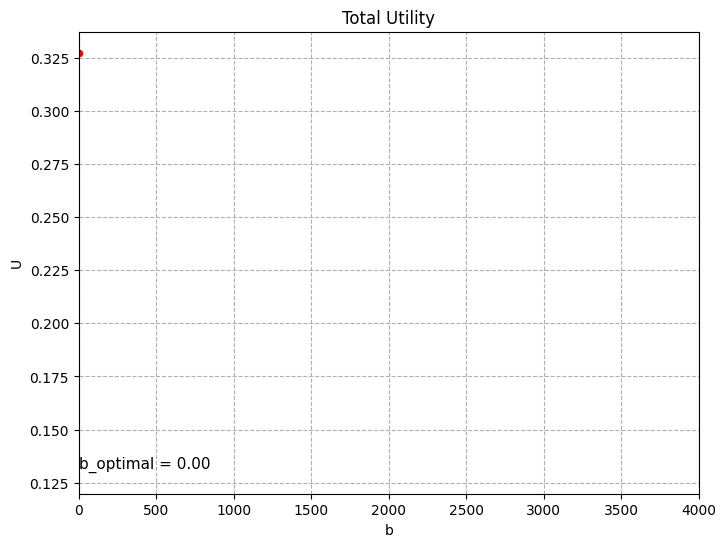

In [ ]:
from google.colab import files



# Calculate results
results, max_b, max_qb = calculate_parameters_p_lognormal(beta_p, gamma, R, y_lower, y_upper, y_3, y_1, y_mean, sigma, b_num_points, lim)
max_index_uniform_p_1 = np.argmax(results['U'])
max_b_uniform_p_1 = results['b'][max_index_uniform_p_1]

max_index_uniform_p_1_qb = np.argmax(results['qb'])
max_b_uniform_qb_p_1 = results['b'][max_index_uniform_p_1_qb]


#psi = np.log(y_3) - np.log(gamma * y_3)
#b_upper_p_1 = (1 - gamma * np.exp(- beta_p_1 * psi)) * y_upper
#b_lower_p_1 = (1 - gamma * np.exp(- beta_p_1 * psi)) * y_lower

plt.figure(figsize=(8, 6))
plt.plot(results['b'], results['U'], alpha=1, color='black', linewidth=0.8)
plt.title('Total Utility')
plt.xlabel('b')
plt.ylabel('U')
#plt.xlim(100, 150)
#plt.ylim(14.375, 14.405)
plt.xlim(0, 4000)
plt.grid(True, linestyle='--')
plt.scatter(max_b_uniform_p_1, results['U'][max_index_uniform_p_1], color='red', zorder=2, s=20)
plt.axvline(x=max_b_uniform_p_1, color='black', linestyle='--', linewidth=0.4)
plt.text(max_b, min(results['U']), f'b_optimal = {max_b:.2f}', verticalalignment='bottom', horizontalalignment='left', rotation=0, color='black', fontsize=11)
#plt.axvspan(0, b_lower_p_1, color='blue', alpha=0.2)
#plt.axvspan(b_lower_p_1, b_upper_p_1, color='red', alpha=0.2)
#plt.axvspan(b_upper_p_1, 1.5*b_upper_p_1, color='yellow', alpha=0.2)
#plt.savefig('gamma_05_beta_05.png')
plt.show()
#files.download('gamma_05_beta_05.png')

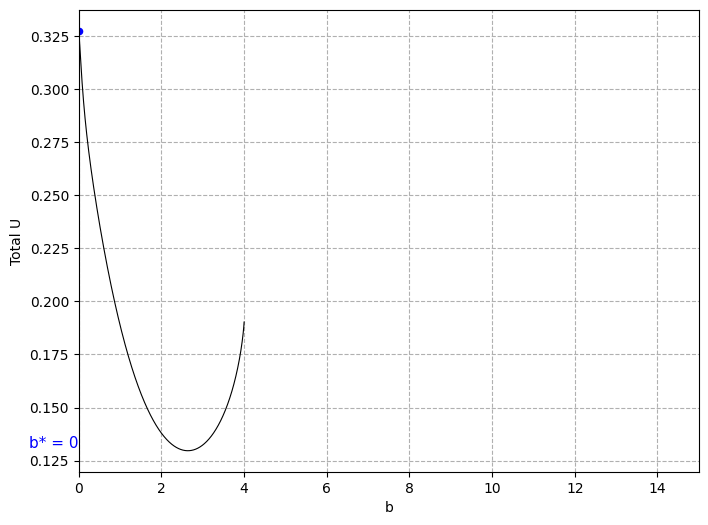

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(results['b'], results['U'], alpha=1, color='black', linewidth=0.8)
#plt.title('Total Utility')
plt.xlabel('b')
plt.ylabel('Total U')
plt.xlim(0, 15)
#plt.ylim(0, 2000)
plt.grid(True, linestyle='--')
plt.scatter(max_b_uniform_p_1, results['U'][max_index_uniform_p_1], color='blue', zorder=2, s=20)
plt.axvline(x=max_b_uniform_p_1, color='blue', linestyle='--', linewidth=0.4)
plt.text(max_b, min(results['U']), f'b* = {max_b:.0f}', verticalalignment='bottom', horizontalalignment='right', rotation=0, color='blue', fontsize=11)
#plt.axvspan(0, b_lower_p_1, color='blue', alpha=0.2)
#plt.axvspan(b_lower_p_1, b_upper_p_1, color='red', alpha=0.2)
#plt.axvspan(b_upper_p_1, 1.5*b_upper_p_1, color='yellow', alpha=0.2)
plt.savefig('tot.png')
plt.show()
files.download('tot.png')

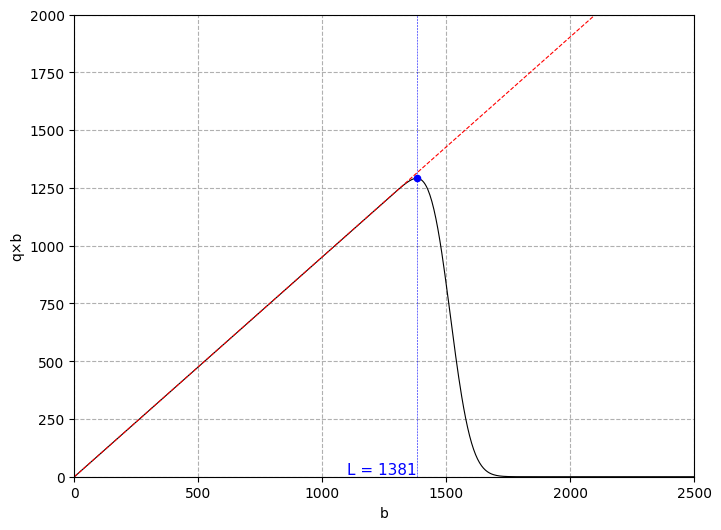

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(results['b'], results['qb'], alpha=1, color='black', linewidth=0.8)
#plt.title('Total Utility')
plt.xlabel('b')
plt.ylabel('q×b')
plt.xlim(0, 2500)
plt.ylim(0, 2000)
plt.grid(True, linestyle='--')
plt.scatter(max_b_uniform_qb_p_1, results['qb'][max_index_uniform_p_1_qb], color='blue', zorder=2, s=20)
plt.axvline(x=max_b_uniform_qb_p_1, color='blue', linestyle='--', linewidth=0.4)
plt.text(max_qb, min(results['qb']), f'L = {max_qb:.0f}', verticalalignment='bottom', horizontalalignment='right', rotation=0, color='blue', fontsize=11)
plt.plot(results['b'], results['b'] / R, label=f'R*b (R={R})', color='red', linestyle='--', linewidth=0.8)
#plt.savefig('gamma_05_beta_05.png')
plt.show()
#files.download('gamma_05_beta_05.png')

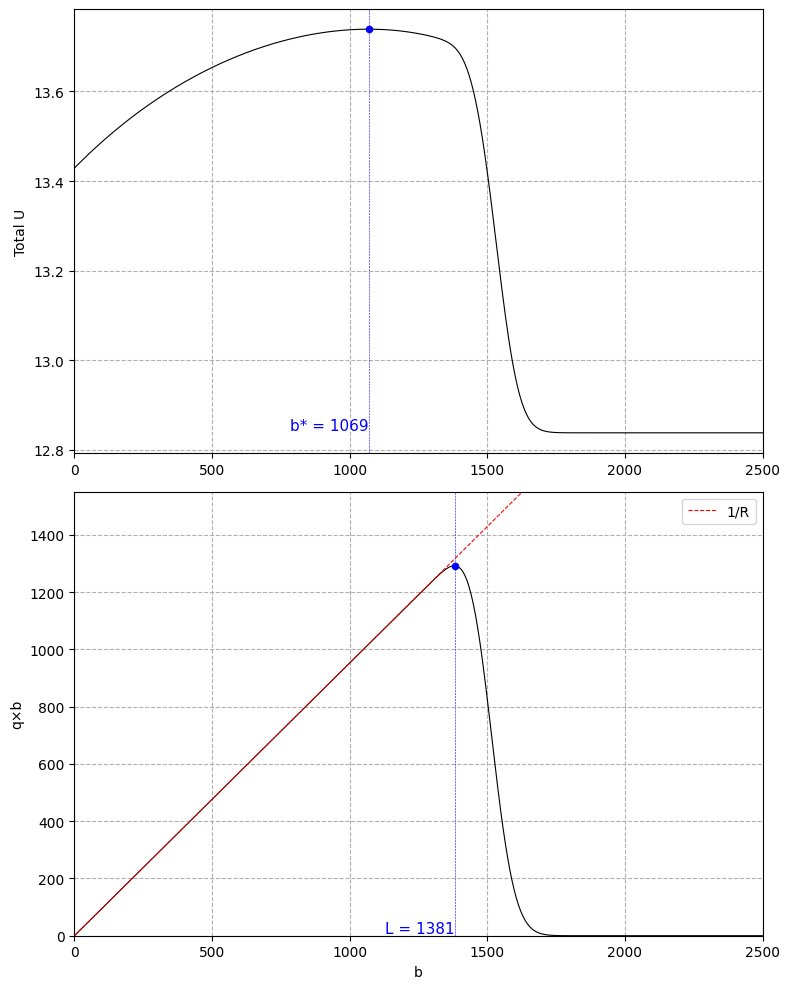

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Assuming results, max_b_uniform_p_1, max_index_uniform_p_1, max_b, max_qb,
# max_b_uniform_qb_p_1, max_index_uniform_p_1_qb, R are all defined

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))  # Create two subplots vertically

# First plot: Total U vs. b
ax1.plot(results['b'], results['U'], alpha=1, color='black', linewidth=0.8)
#ax1.set_xlabel('b')
ax1.set_ylabel('Total U')
ax1.set_xlim(0, 2500)
ax1.grid(True, linestyle='--')
ax1.scatter(max_b_uniform_p_1, results['U'][max_index_uniform_p_1], color='blue', zorder=2, s=20)
ax1.axvline(x=max_b_uniform_p_1, color='blue', linestyle='--', linewidth=0.4)
ax1.text(max_b, min(results['U']), f'b* = {max_b:.0f}', verticalalignment='bottom', horizontalalignment='right', rotation=0, color='blue', fontsize=11)

# Second plot: q×b vs. b
ax2.plot(results['b'], results['qb'], alpha=1, color='black', linewidth=0.8)
ax2.set_xlabel('b')
ax2.set_ylabel('q×b')
ax2.set_xlim(0, 2500)
ax2.set_ylim(0, results['qb'][max_index_uniform_p_1_qb] * 1.2)
ax2.grid(True, linestyle='--')
ax2.scatter(max_b_uniform_qb_p_1, results['qb'][max_index_uniform_p_1_qb], color='blue', zorder=2, s=20)
ax2.axvline(x=max_b_uniform_qb_p_1, color='blue', linestyle='--', linewidth=0.4)
ax2.text(max_qb, min(results['qb']), f'L = {max_qb:.0f}', verticalalignment='bottom', horizontalalignment='right', rotation=0, color='blue', fontsize=11)
ax2.plot(results['b'], results['b'] / R, label='1/R', color='red', linestyle='--', linewidth=0.8)
ax2.legend()

plt.tight_layout()  # Adjust layout to prevent overlap
plt.savefig('combined_u.png')
plt.show()
files.download('combined_u.png')

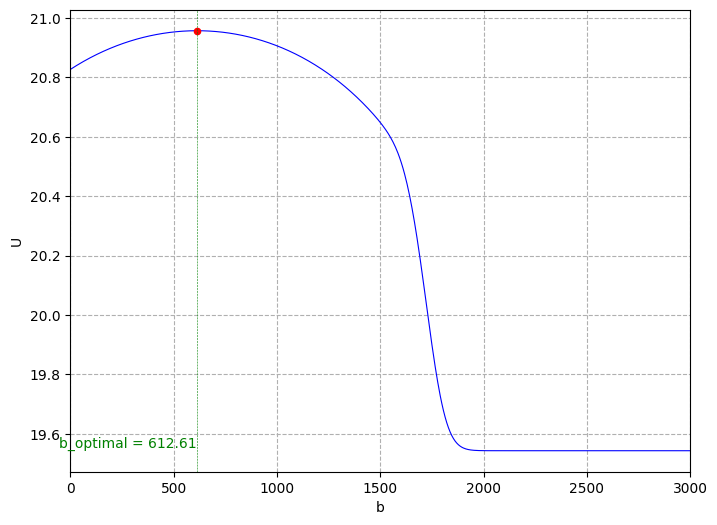

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(results['b'], results['U'], alpha=1, color='blue', linewidth=0.8)
#plt.title('Total Utility')
plt.xlabel('b')
plt.ylabel('U')
#plt.xlim(100, 150)
#plt.ylim(14.375, 14.405)
plt.xlim(0, 3000)
plt.grid(True, linestyle='--')
plt.scatter(max_b_uniform_p_1, results['U'][max_index_uniform_p_1], color='red', zorder=2, s=20)
plt.axvline(x=max_b_uniform_p_1, color='green', linestyle='--', linewidth=0.4)
plt.text(max_b, min(results['U']), f'b_optimal = {max_b:.2f}', verticalalignment='bottom', horizontalalignment='right', rotation=0, color='green', fontsize=10)
#plt.axvspan(0, b_lower_p_1, color='blue', alpha=0.2)
#plt.axvspan(b_lower_p_1, b_upper_p_1, color='red', alpha=0.2)
#plt.axvspan(b_upper_p_1, 1.5*b_upper_p_1, color='yellow', alpha=0.2)
plt.savefig('gamma_05_beta_05_lognormal.png')
plt.show()
files.download('gamma_05_beta_05_lognormal.png')

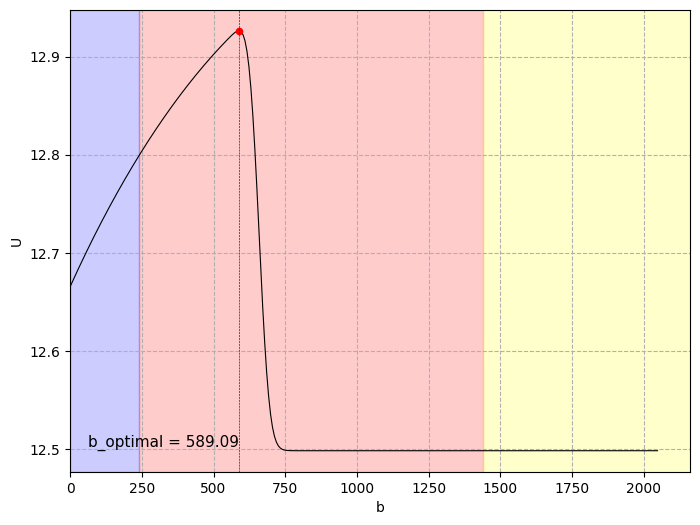

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# plt.figure(figsize=(8, 6))
# plt.plot(results['b'], results['U'], alpha=1, color='black', linewidth=0.8)
# #plt.title('Total Utility')
# plt.xlabel('b')
# plt.ylabel('U')
# #plt.xlim(100, 150)
# #plt.ylim(14.375, 14.405)
# plt.xlim(0, 1.5*b_upper_p_1)
# plt.grid(True, linestyle='--')
# plt.scatter(max_b_uniform_p_1, results['U'][max_index_uniform_p_1], color='red', zorder=2, s=20)
# plt.axvline(x=max_b_uniform_p_1, color='black', linestyle='--', linewidth=0.4)
# plt.text(max_b_uniform_p_1, min(results['U']), f'b_optimal = {max_b_uniform_p_1:.2f}', verticalalignment='bottom', horizontalalignment='right', rotation=0, color='black', fontsize=11)
# plt.axvspan(0, b_lower_p_1, color='blue', alpha=0.2)
# plt.axvspan(b_lower_p_1, b_upper_p_1, color='red', alpha=0.2)
# plt.axvspan(b_upper_p_1, 1.5*b_upper_p_1, color='yellow', alpha=0.2)
# plt.savefig('gamma_05_beta_095_lognormal.png')
# plt.show()
# files.download('gamma_05_beta_095_lognormal.png')

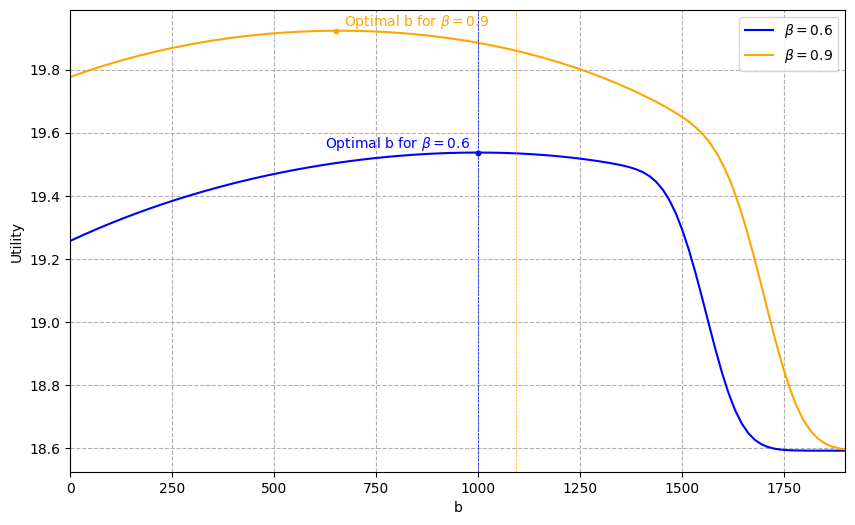

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# beta_p_1 = 0.6
# beta_p_2 = 0.9


# results_1, max_b = calculate_parameters_p_lognormal(beta_p_1, gamma, R, y_lower, y_upper, y_3, y_1, y_mean, sigma, b_num_points, lim)
# results_2, max_b = calculate_parameters_p_lognormal(beta_p_2, gamma, R, y_lower, y_upper, y_3, y_1, y_mean, sigma, b_num_points, lim)

# max_index_uniform_p_1 = np.argmax(results_1['U'])
# max_b_uniform_p_1 = results_1['b'][max_index_uniform_p_1]
# max_index_uniform_p_2 = np.argmax(results_2['U'])
# max_b_uniform_p_2 = results_2['b'][max_index_uniform_p_1]

# # Example x-value where we want to calculate the difference
# x_target = 2000

# # Assuming results_1['b'] and results_2['b'] contain continuous numerical data similar to an index,
# # We need to find the point closest to x_target in both datasets
# idx_closest_blue = (np.abs(results_1['b'] - x_target)).idxmin()
# idx_closest_orange = (np.abs(results_2['b'] - x_target)).idxmin()

# # Calculate the difference in y-values at these points
# y_diff = results_2['U'][idx_closest_orange] - results_1['U'][idx_closest_blue]

# # Add this difference to all y-values of the blue dataset
# results_1_adjusted = results_1['U'] + y_diff

# # Plotting the adjusted results
# plt.figure(figsize=(10, 6))
# plt.plot(results_1['b'], results_1_adjusted, label='$\\beta =0.6$', color='blue', linestyle='-')
# plt.plot(results_2['b'], results_2['U'], label='$\\beta =0.9$', color='orange')

# # Scatter plot points with smaller size (e.g., s=50)
# plt.scatter(results_1['b'][max_index_uniform_p_1], results_1_adjusted[max_index_uniform_p_1], color='blue', s=10, zorder=5)
# plt.scatter(results_2['b'][max_index_uniform_p_2], results_2['U'][max_index_uniform_p_2], color='orange', s=10, zorder=5)

# # Vertical lines at the points of max_b
# plt.axvline(x=max_b_uniform_p_1, color='blue', linestyle='--', linewidth=0.5)
# plt.axvline(x=max_b_uniform_p_2, color='orange', linestyle='--', linewidth=0.5)
# x_text_offset = 20  # Adjust this value based on your x-axis scale to position the text
# plt.text(results_1['b'][max_index_uniform_p_1] - x_text_offset, results_1_adjusted[max_index_uniform_p_1], 'Optimal b for $\\beta =0.6$', color='blue', verticalalignment='bottom', horizontalalignment='right')
# plt.text(results_2['b'][max_index_uniform_p_2] + x_text_offset, results_2['U'][max_index_uniform_p_2], 'Optimal b for $\\beta =0.9$', color='orange', verticalalignment='bottom', horizontalalignment='left')
# # Labeling and aesthetics
# #plt.title('Utility vs. b (Adjusted)')
# plt.xlabel('b')
# plt.ylabel('Utility')
# plt.xlim(0, 1900)
# plt.legend()
# plt.grid(True, linestyle='--')
# #plt.savefig('u_beta_06_09.png')
# plt.show()
# #files.download('u_beta_06_09.png')

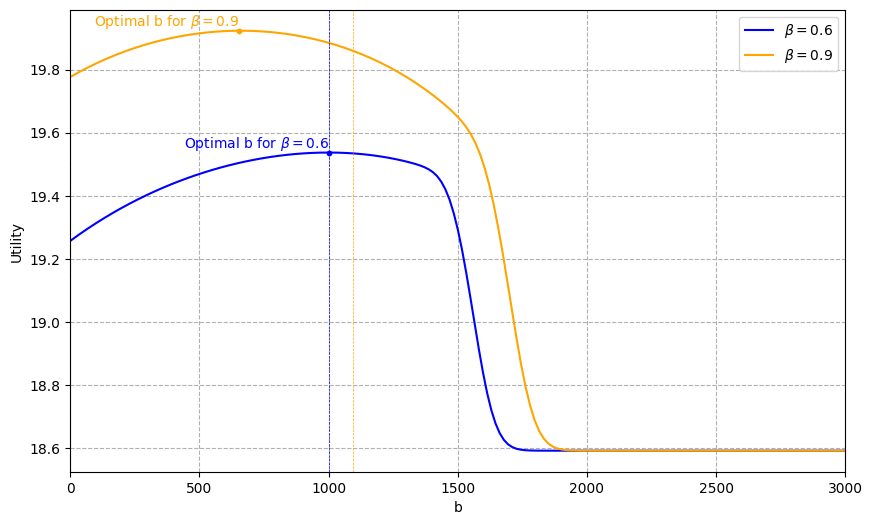

In [ ]:
# # Plotting the adjusted results
# plt.figure(figsize=(10, 6))
# plt.plot(results_1['b'], results_1_adjusted, label='$\\beta =0.6$', color='blue', linestyle='-')
# plt.plot(results_2['b'], results_2['U'], label='$\\beta =0.9$', color='orange')

# # Scatter plot points with smaller size (e.g., s=50)
# plt.scatter(results_1['b'][max_index_uniform_p_1], results_1_adjusted[max_index_uniform_p_1], color='blue', s=10, zorder=5)
# plt.scatter(results_2['b'][max_index_uniform_p_2], results_2['U'][max_index_uniform_p_2], color='orange', s=10, zorder=5)

# # Vertical lines at the points of max_b
# plt.axvline(x=max_b_uniform_p_1, color='blue', linestyle='--', linewidth=0.5)
# plt.axvline(x=max_b_uniform_p_2, color='orange', linestyle='--', linewidth=0.5)
# x_text_offset = 0  # Adjust this value based on your x-axis scale to position the text
# plt.text(results_1['b'][max_index_uniform_p_1] - x_text_offset, results_1_adjusted[max_index_uniform_p_1], 'Optimal b for $\\beta =0.6$', color='blue', verticalalignment='bottom', horizontalalignment='right')
# plt.text(results_2['b'][max_index_uniform_p_2] - x_text_offset, results_2['U'][max_index_uniform_p_2], 'Optimal b for $\\beta =0.9$', color='orange', verticalalignment='bottom', horizontalalignment='right')
# # Labeling and aesthetics
# #plt.title('Utility vs. b (Adjusted)')
# plt.xlabel('b')
# plt.ylabel('Utility')
# plt.xlim(0, 3000)
# plt.legend()
# plt.grid(True, linestyle='--')
# #plt.savefig('u_beta_06_09_lognormal.png')
# plt.show()
# #files.download('u_beta_06_09_lognormal.png')